# GPs with Cholesky, CG, and RFFs

In [1]:
import gpytorch

In [ ]:
test_func = gpytorch.kernels

In [129]:
import math
import torch
import warnings
import gpytorch
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

### Set up training/evaluation data

In [130]:
train_x = torch.linspace(0, 1, 200)
train_y = torch.sin(train_x * (5 * math.pi)) * train_x + torch.randn_like(train_x) * 0.1
test_x = torch.linspace(-1, 2, 151)

### Model for Cholesky/CG

In [131]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(), 
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [132]:
help(gpytorch.kernels.ScaleKernel)

Help on class ScaleKernel in module gpytorch.kernels.scale_kernel:

class ScaleKernel(gpytorch.kernels.kernel.Kernel)
 |  ScaleKernel(base_kernel, outputscale_prior=None, outputscale_constraint=None, **kwargs)
 |  
 |  Decorates an existing kernel object with an output scale, i.e.
 |  
 |  .. math::
 |  
 |     \begin{equation*}
 |        K_{\text{scaled}} = \theta_\text{scale} K_{\text{orig}}
 |     \end{equation*}
 |  
 |  where :math:`\theta_\text{scale}` is the `outputscale` parameter.
 |  
 |  In batch-mode (i.e. when :math:`x_1` and :math:`x_2` are batches of input matrices), each
 |  batch of data can have its own `outputscale` parameter by setting the `batch_shape`
 |  keyword argument to the appropriate number of batches.
 |  
 |  .. note::
 |      The :attr:`outputscale` parameter is parameterized on a log scale to constrain it to be positive.
 |      You can set a prior on this parameter using the :attr:`outputscale_prior` argument.
 |  
 |  Args:
 |      :attr:`base_kernel`

### Model for RFFs (uses a different kernel)

In [133]:
class GPRegressionModelRFF(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_rff_samples):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RFFKernel(num_samples=num_rff_samples),  # This is the different line!
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Training/testing scripts

parameters:

1. `model.covar_module.base_kernel.parameters()` includes only lengthscale in the RBF kernel

2. `model.covar_module.parameters()`, which is the kernel wrapped by `ScaleKernel` function that adds an outputscale parameter, we have both lengthscale and outputscale parameters

3. `model.parameters()` gives four parameters. it includes the likelihood noise and also a mean parameter.

In [134]:
for i in model.named_parameters():
    print(i)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([0.], requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[2.6559]], requires_grad=True))


In [1]:
def train(model, likelihood, name=""):
    likelihood.initialize(noise=0.01)

    optimizer = torch.optim.Adam(model.covar_module.base_kernel.parameters(),
                                 lr=0.05)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    model.train()
    iterator = tqdm(range(500), desc=f"{name} Training")

    for i in iterator:
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y) # output.log_prob(train_y) dep on inv_log_det_quad
        loss.backward()
        optimizer.step()
        iterator.set_post54fix(
            loss=loss.item(),
            ls=model.covar_module.base_kernel.lengthscale.item(),
            os=model.covar_module.outputscale.item(),
            noise=likelihood.noise.item())

        # Reset RFF weights
        # syntax explained in https://discuss.pytorch.org/t/what-is-the-src-code-for-tensor-normal-or-what-formula-does-it-use-under-the-hood/44650/4
        if hasattr(model.covar_module.base_kernel, "randn_weights"):
            model.covar_module.base_kernel.randn_weights.normal_()

In [139]:
def eval(model, likelihood, name=""):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        prediction = likelihood(model(test_x))
        mean = prediction.mean
        lower, upper = prediction.confidence_region()
        ax.plot(train_x.numpy(), train_y.numpy(), "k*", label="Training Data")
        ax.plot(test_x.numpy(), mean.numpy(), "b", label="Prediction")
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set(xlabel="x", ylabel="y", title=name, ylim=(-6., 6.))

    return fig


## Cholesky training/evaluation

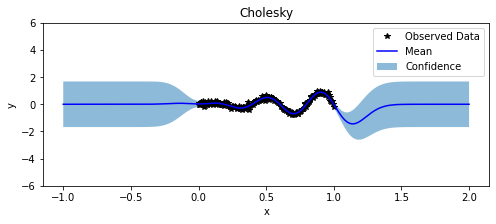

In [140]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

# Force GPyTorch to use Cholesky
with gpytorch.settings.max_cholesky_size(10000000):
    train(model, likelihood, name="Cholesky")
    eval(model, likelihood, name="Cholesky")

# CG training/evaluation

In [141]:
def CG_training(model, likelihood, num_cg):
    '''mostly setting up the context managers to force GPyTorch to use CG and not Cholesky,
    and to allow for a small number of them. assuming that train is 
    defined outside of this function (change in future).
    GPs with kernel matrices that are smaller than max_cholesky_size use Cholesky for inference. 
    If the matrix is bigger than max_cholesky_size, then GPyTorch uses CG for inference.
    By setting max_cholesky_size(10000000000), 
    we’re forcing GPyTorch to use Cholesky for evaluation (after using CG for kernel learning). It doesn’t make a huge difference in this scenario.'''

    # Force GPyTorch to use CG
    # We'll also hard-code the number of iterations
    with gpytorch.settings.max_cholesky_size(0):

        # Silence CG-related warnings
        warnings.simplefilter("ignore", gpytorch.utils.warnings.NumericalWarning)

        # Since the tolerance is impossibly low, GPyTorch will be
        # forced to use the `max_cg_iterations` stopping criterion
        # We'll also not use the preconditioner
        with gpytorch.settings.max_cg_iterations(num_cg), gpytorch.settings.max_lanczos_quadrature_iterations(num_cg):
            with gpytorch.settings.cg_tolerance(1e-50):

                # To make the effects of early termination more dramatic, we'll turn off the preconditioner
                with gpytorch.settings.max_preconditioner_size(0):  # Default is usually 10
                    train(model, likelihood, name="CG")

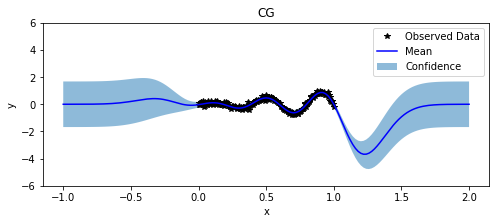

In [142]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)
num_cg = 5
# train
CG_training(model, likelihood, num_cg) # context managing around train()
# eval
with gpytorch.settings.max_cholesky_size(100000000):
    eval(model, likelihood, name="CG")

In [143]:
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = GPRegressionModel(train_x, train_y, likelihood)

# # Force GPyTorch to use CG
# # We'll also hard-code the number of iterations
# with gpytorch.settings.max_cholesky_size(0):
    
#     # Silence CG-related warnings
#     warnings.simplefilter("ignore", gpytorch.utils.warnings.NumericalWarning)
    
#     # Since the tolerance is impossibly low, GPyTorch will be
#     # forced to use the `max_cg_iterations` stopping criterion
#     # We'll also not use the preconditioner
#     num_cg = 5
#     with gpytorch.settings.max_cg_iterations(num_cg), gpytorch.settings.max_lanczos_quadrature_iterations(num_cg):
#         with gpytorch.settings.cg_tolerance(1e-50):
        
#             # To make the effects of early termination more dramatic, we'll turn off the preconditioner
#             with gpytorch.settings.max_preconditioner_size(0):  # Default is usually 10
#                 train(model, likelihood, name="CG")

# # We can use a more strict CG convergence criterion for evaluation
# with gpytorch.settings.max_cholesky_size(100000000):
#     #model.train()
#     eval(model, likelihood, name="CG")

## RFF training/evaluation

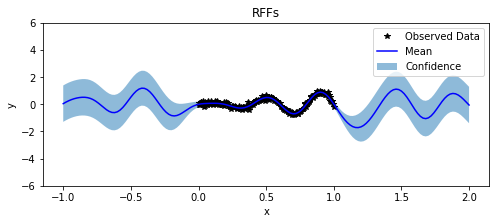

In [144]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Control the number of RFF samples here!
model = GPRegressionModelRFF(train_x, train_y, likelihood, num_rff_samples=20)

# Force GPyTorch to use Cholesky
with gpytorch.settings.max_cholesky_size(10000000):
    train(model, likelihood, name="RFFs")
    eval(model, likelihood, name="RFFs")

### sample from prior and posterior
In this section I show how to sample from the prior and the posterior,
without training.

In [145]:
# initialize instances and set params
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood) 
    
'''see basic usage tutorial on 
https://docs.gpytorch.ai/en/v1.2.0/examples/00_Basic_Usage/Hyperparameters.html'''
hypers = {
'likelihood.noise_covar.noise': torch.tensor(.001),
'covar_module.base_kernel.lengthscale': torch.tensor(.3),
'covar_module.outputscale': torch.tensor(2.),
}

model.initialize(**hypers)
print(
    model.likelihood.noise_covar.noise.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item()
)
print('showing named parameters:')
print(list(model.named_parameters()))

0.0009999999310821295 0.30000004172325134 2.0
showing named parameters:
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-7.0127], requires_grad=True)), ('mean_module.constant', Parameter containing:
tensor([0.], requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(1.8546, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-1.0502]], requires_grad=True))]


In [146]:
def sample_from_prior(model, likelihood, train_x):
    # https://github.com/cornellius-gp/gpytorch/pull/707
    with gpytorch.settings.prior_mode(True):
        prior_preds = likelihood(model(train_x))
    return prior_preds.sample()

(-5.0, 5.0)

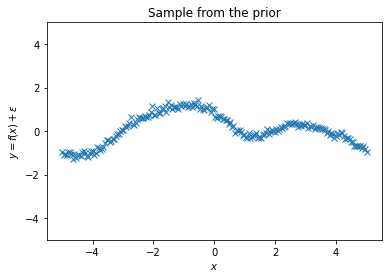

In [190]:
# showing how to take a sample from the prior
torch.manual_seed(0)
prior_sample = sample_from_prior(model, likelihood, train_x)
plt.plot(train_x, prior_sample.detach().numpy(), 'x')
plt.title('Sample from the prior');
plt.xlabel(r'$x$');
plt.ylabel(r'$y = f(x) + \epsilon$');
plt.ylim([-5,5])

In [191]:
# Set into posterior mode and take a sample (no training)
model.eval()
likelihood.eval()

post_preds = likelihood(model(train_x)) # post predictive distribution
post_sample = post_preds.sample() # sample from it

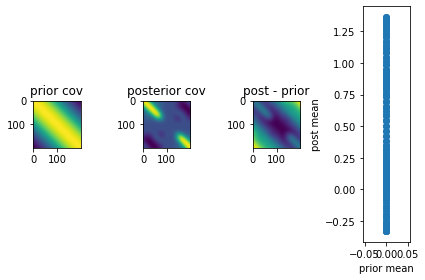

In [192]:
plt.subplot(141)
plt.title('prior cov')
plt.imshow(prior_preds.covariance_matrix.detach().numpy())
plt.subplot(142)
plt.title('posterior cov')
plt.imshow(post_preds.covariance_matrix.detach().numpy())
plt.subplot(143)
plt.title('post - prior')
plt.imshow(post_preds.covariance_matrix.detach().numpy() - 
          prior_preds.covariance_matrix.detach().numpy())
plt.subplot(144)
plt.scatter(prior_preds.loc.detach().numpy(),
            post_preds.loc.detach().numpy())
plt.xlabel('prior mean')
plt.ylabel('post mean')
plt.tight_layout()

### Experiments: varying RFF and CG samples

In [327]:
#np.concatenate([np.array(10), np.arange(20,31,10)])
np.linspace(20,30,10)
np.concatenate((np.array([10,50]), np.arange(20,30,10)))

array([10, 50, 20])

In [331]:
# parameters of the experiment
lengthscale_vec = np.linspace(0.1, 2, 11) 
RFF_samples = np.concatenate((np.array([10,50]), np.arange(100,1000,100), np.arange(1000,3000, 250))) 
CG_iters = np.arange(4, 54, 4)
print('experimental params:')
print('lengthscales:')
print(lengthscale_vec)
print('RFF samples:')
print(RFF_samples)
print('CG_iters:')
print(CG_iters)

experimental params:
lengthscales:
[0.1  0.29 0.48 0.67 0.86 1.05 1.24 1.43 1.62 1.81 2.  ]
RFF samples:
[  10   50  100  200  300  400  500  600  700  800  900 1000 1250 1500
 1750 2000 2250 2500 2750]
CG_iters:
[ 4  8 12 16 20 24 28 32 36 40 44 48 52]


In [332]:
train_x = torch.linspace(-3, 3, 200)
train_y = torch.sin(train_x * (5 * math.pi)) * train_x + torch.randn_like(train_x) * 0.1
test_x = torch.linspace(-4, 5, 151)

In [333]:
# for self: if you want to randomize initial values. 
#torch.clamp(torch.tensor(2.5) + 0.5*torch.randn(1), 0.05)

true lengthscale= 0.10


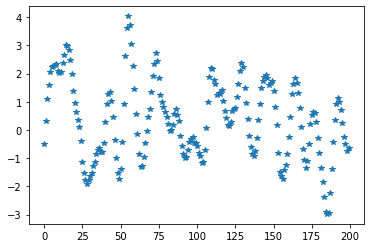

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


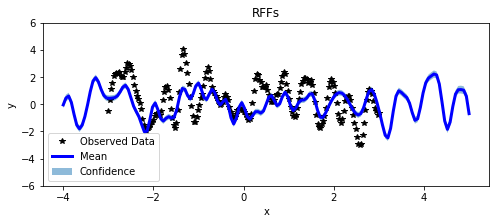

post training lengthscale
0.10358957946300507
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


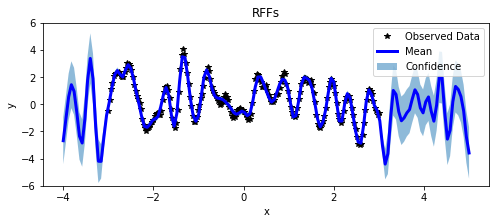

post training lengthscale
0.06832101941108704
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


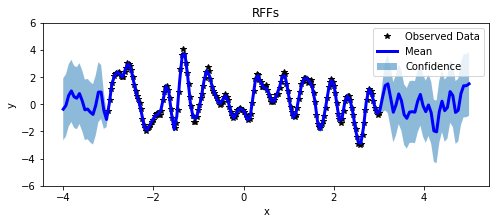

post training lengthscale
0.04975748807191849
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


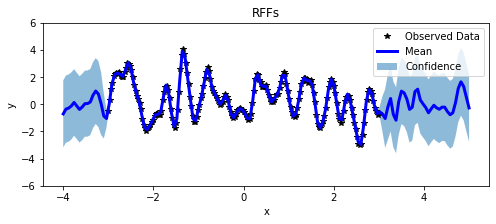

post training lengthscale
0.06575722992420197
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


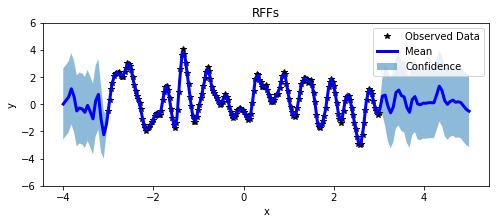

post training lengthscale
0.0703950896859169
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


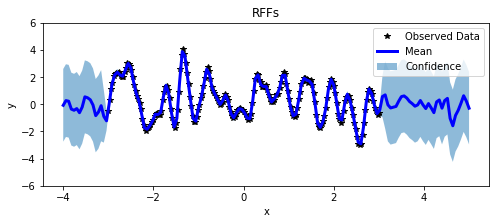

post training lengthscale
0.07268165051937103
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


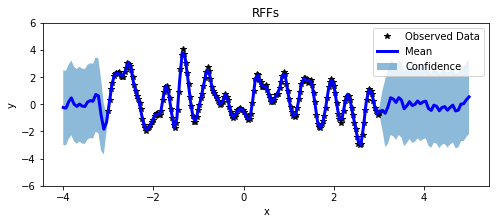

post training lengthscale
0.07408151775598526
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


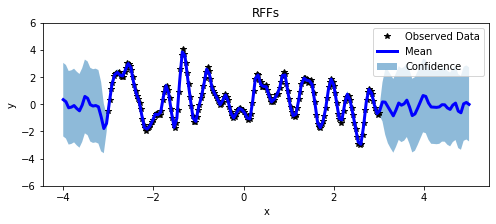

post training lengthscale
0.07531636953353882
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


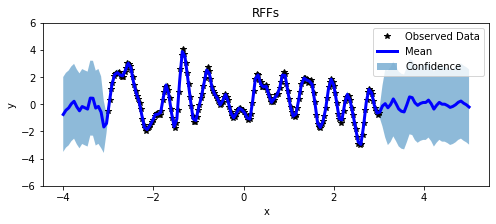

post training lengthscale
0.07533426582813263
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


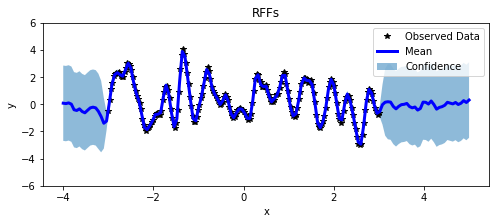

post training lengthscale
0.07980278134346008
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


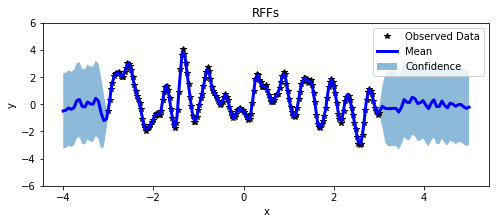

post training lengthscale
0.07918091118335724
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


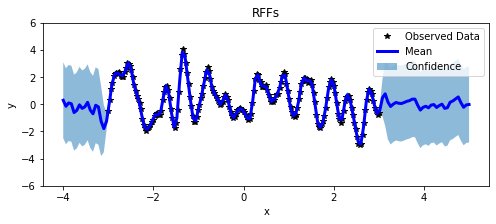

post training lengthscale
0.08457712829113007
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


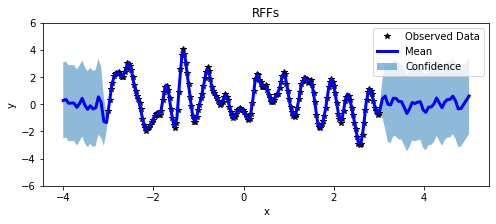

post training lengthscale
0.08125653117895126
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


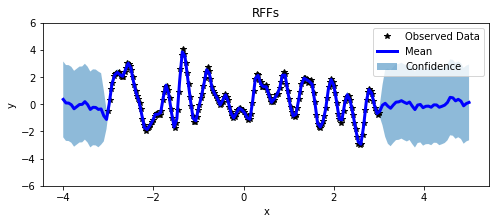

post training lengthscale
0.08173584192991257
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


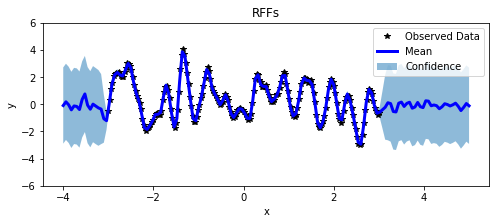

post training lengthscale
0.08644003421068192
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


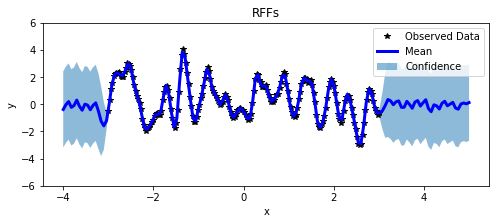

post training lengthscale
0.08815329521894455
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


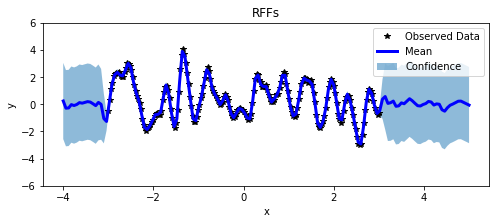

post training lengthscale
0.08536191284656525
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


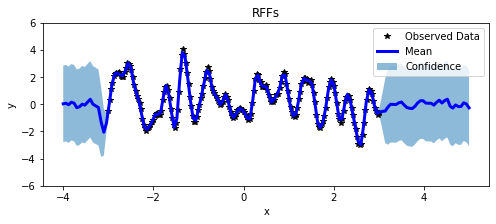

post training lengthscale
0.0889933854341507
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.057112455368042 2.0
1.057112455368042


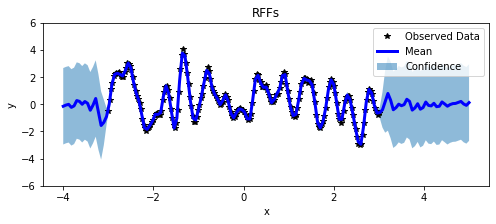

post training lengthscale
0.09297948330640793
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


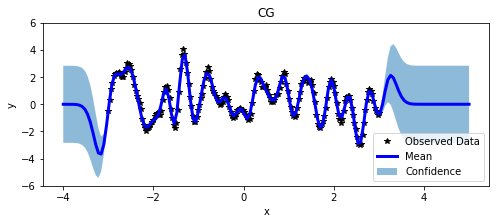

post training lengthscale = 0.20
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


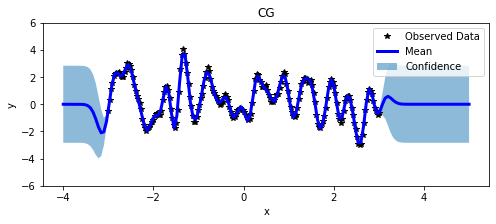

post training lengthscale = 0.15
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


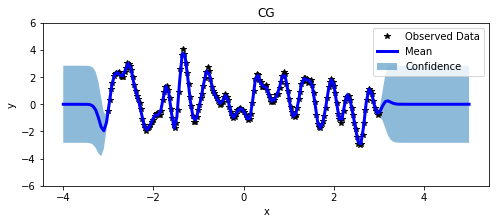

post training lengthscale = 0.12
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


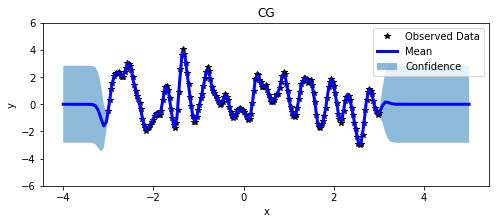

post training lengthscale = 0.11
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


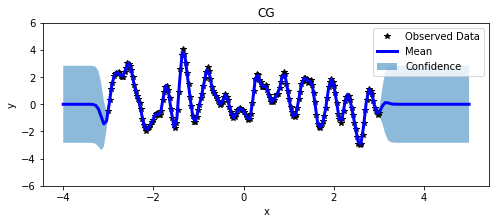

post training lengthscale = 0.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


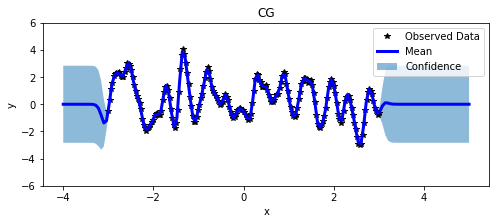

post training lengthscale = 0.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


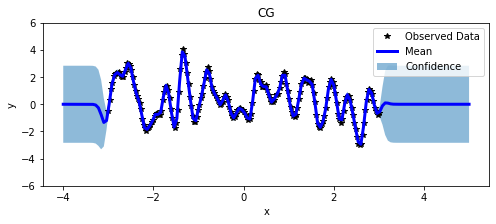

post training lengthscale = 0.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


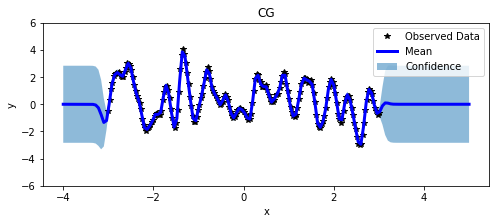

post training lengthscale = 0.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


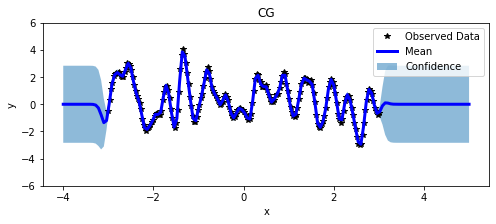

post training lengthscale = 0.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


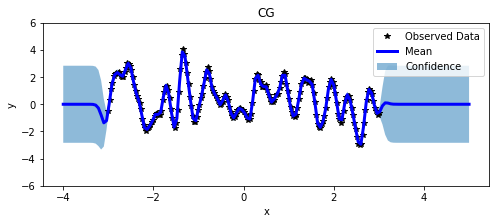

post training lengthscale = 0.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


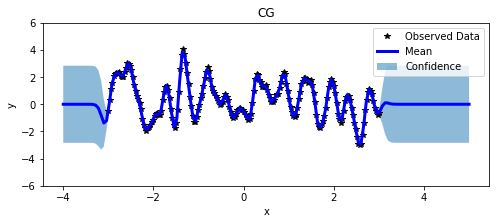

post training lengthscale = 0.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


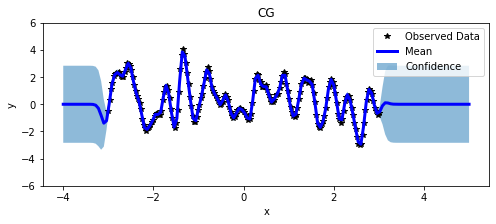

post training lengthscale = 0.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.2367371320724487 2.0
0.09297948330640793


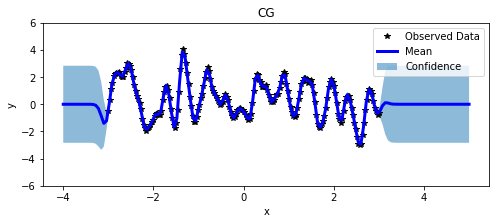

post training lengthscale = 0.10
true lengthscale= 0.29


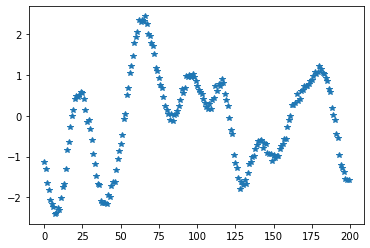

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


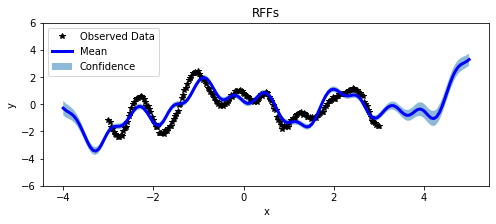

post training lengthscale
0.1625499725341797
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


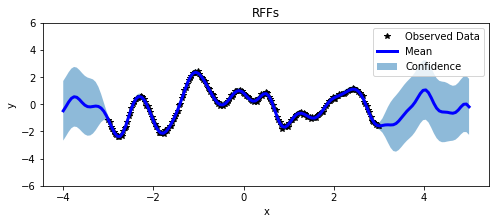

post training lengthscale
0.1624903529882431
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


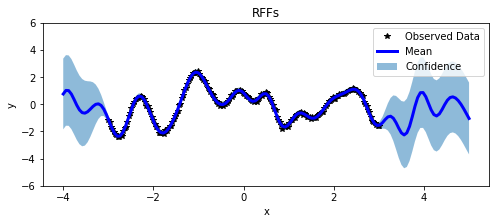

post training lengthscale
0.19862517714500427
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


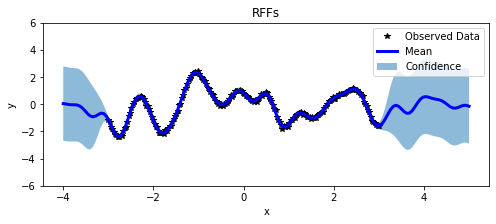

post training lengthscale
0.21348577737808228
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


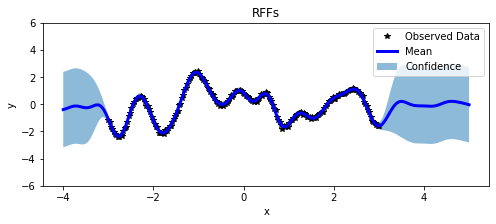

post training lengthscale
0.2264070063829422
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


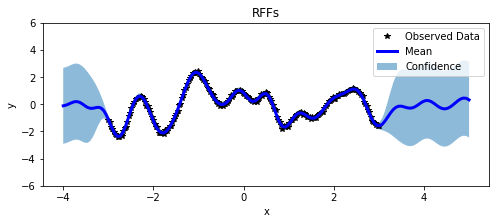

post training lengthscale
0.23058442771434784
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


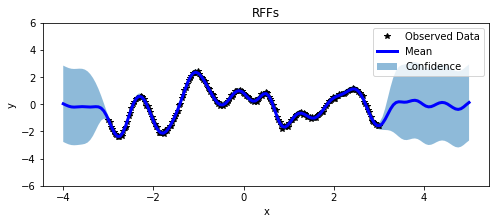

post training lengthscale
0.24545936286449432
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


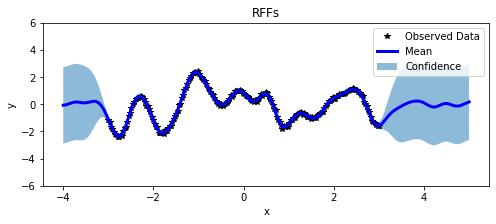

post training lengthscale
0.2522013485431671
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


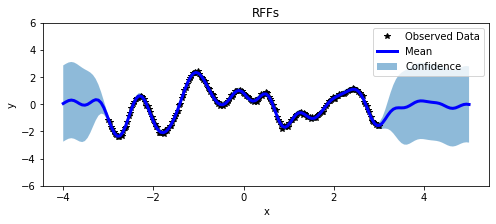

post training lengthscale
0.25651440024375916
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


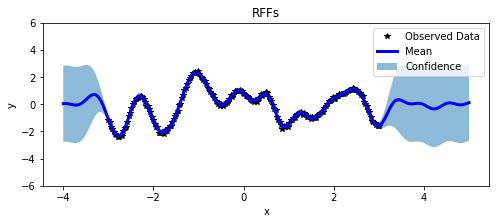

post training lengthscale
0.2559467852115631
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


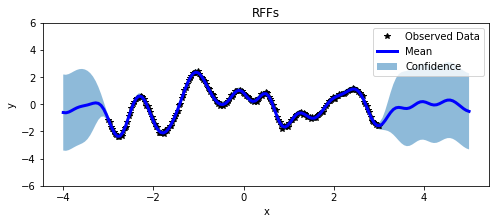

post training lengthscale
0.2602440118789673
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


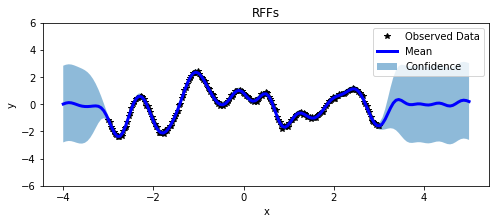

post training lengthscale
0.26134055852890015
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


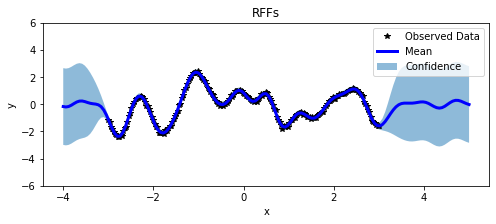

post training lengthscale
0.2721065878868103
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


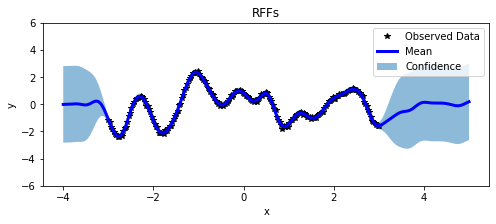

post training lengthscale
0.2709108889102936
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


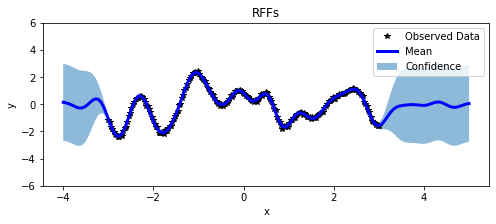

post training lengthscale
0.27355220913887024
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


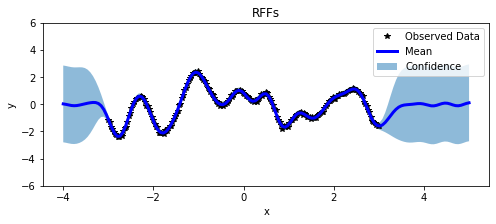

post training lengthscale
0.27898362278938293
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


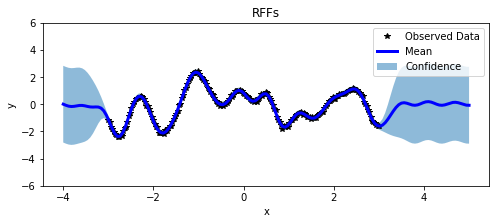

post training lengthscale
0.2720908224582672
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


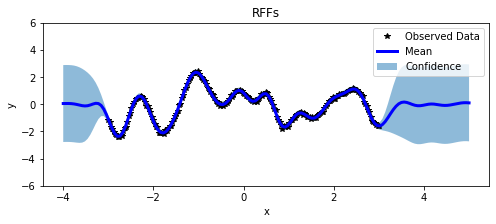

post training lengthscale
0.2791047692298889
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.5403785705566406 2.0
0.5403785705566406


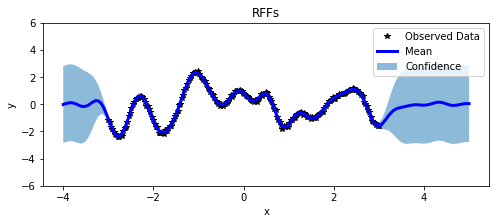

post training lengthscale
0.28119227290153503
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


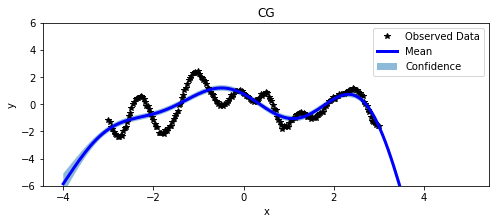

post training lengthscale = 1.62
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


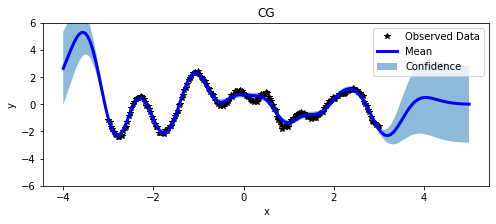

post training lengthscale = 0.51
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


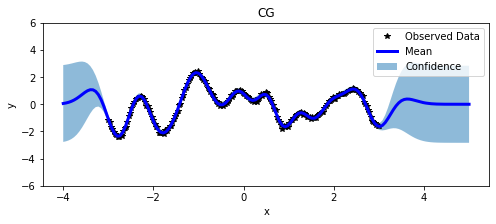

post training lengthscale = 0.37
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


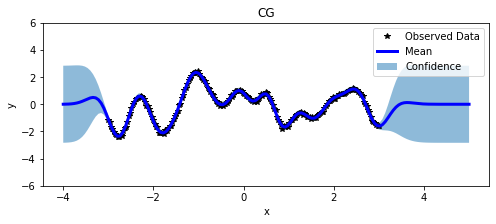

post training lengthscale = 0.32
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


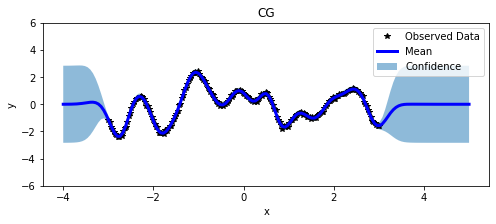

post training lengthscale = 0.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


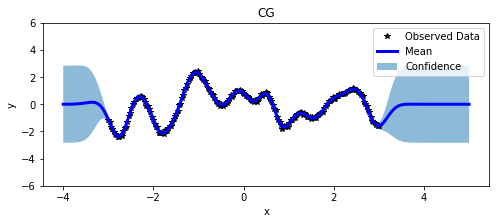

post training lengthscale = 0.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


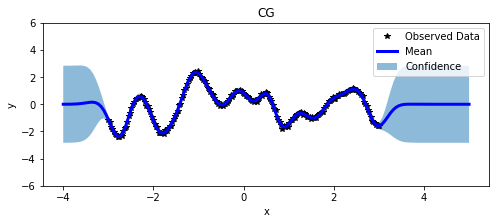

post training lengthscale = 0.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


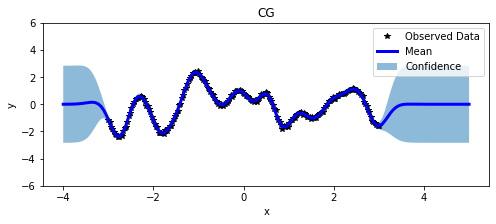

post training lengthscale = 0.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


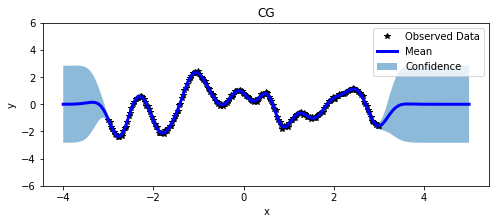

post training lengthscale = 0.27
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


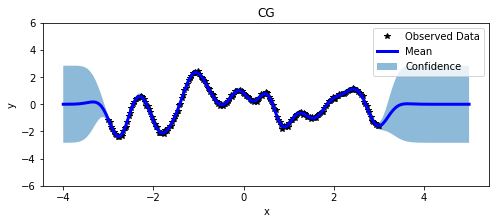

post training lengthscale = 0.28
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


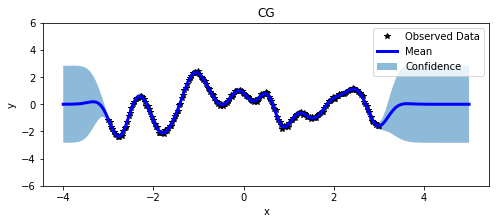

post training lengthscale = 0.29
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


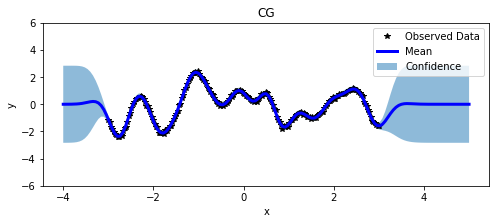

post training lengthscale = 0.29
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.9575810432434082 2.0
0.28119227290153503


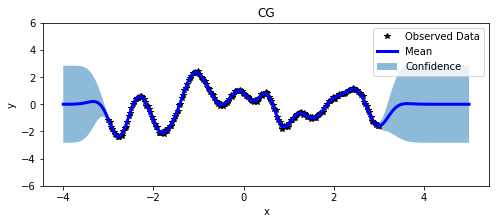

post training lengthscale = 0.29
true lengthscale= 0.48


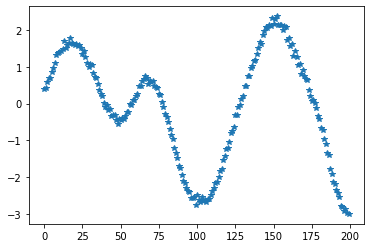

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


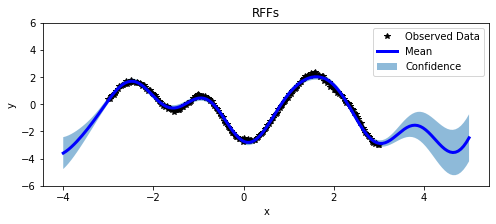

post training lengthscale
0.3053729832172394
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


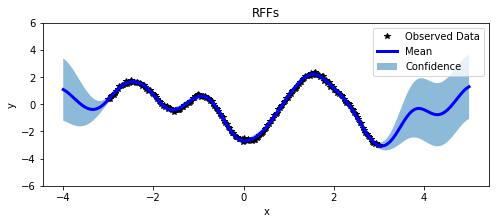

post training lengthscale
0.3160344958305359
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


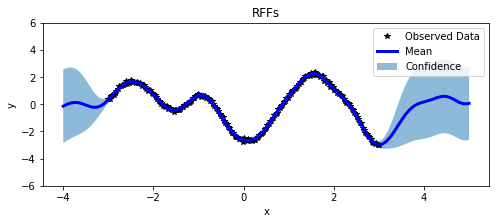

post training lengthscale
0.3529176115989685
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


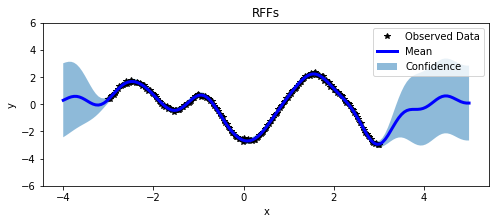

post training lengthscale
0.37812331318855286
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


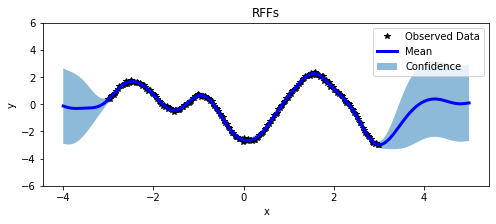

post training lengthscale
0.39616480469703674
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


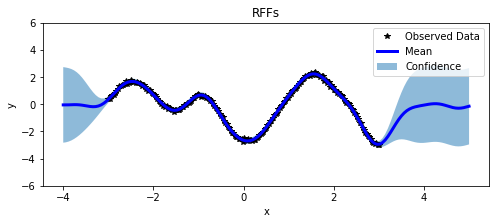

post training lengthscale
0.42155736684799194
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


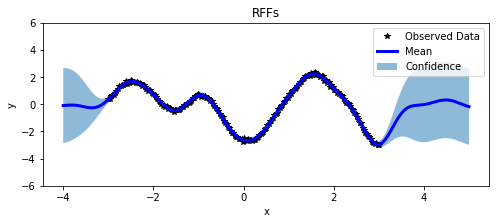

post training lengthscale
0.411472350358963
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


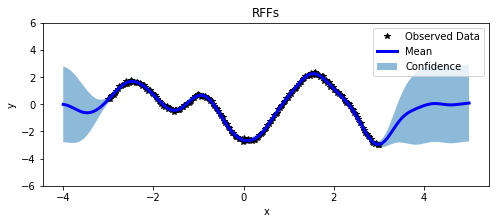

post training lengthscale
0.4194040894508362
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


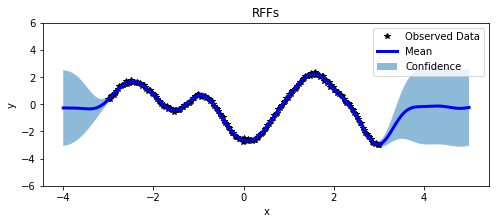

post training lengthscale
0.4298805594444275
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


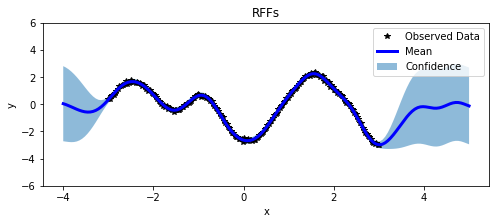

post training lengthscale
0.4327640235424042
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


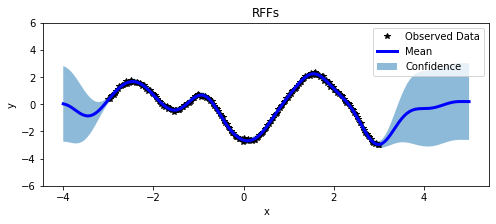

post training lengthscale
0.4347139000892639
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


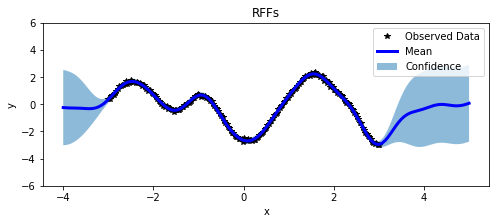

post training lengthscale
0.4358835518360138
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


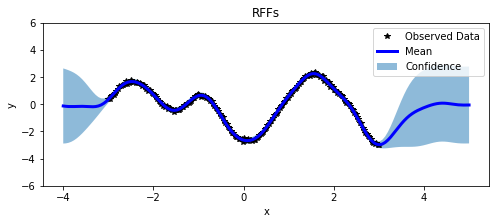

post training lengthscale
0.4438975751399994
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


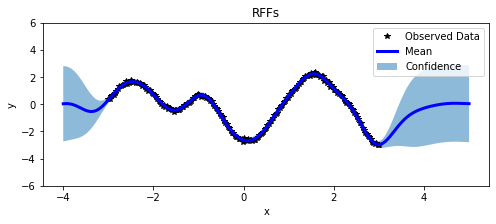

post training lengthscale
0.4503503441810608
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


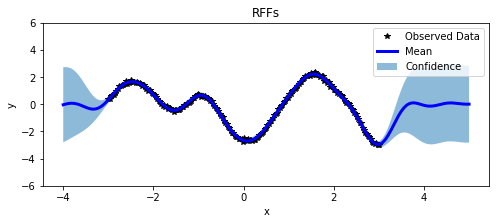

post training lengthscale
0.45236849784851074
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


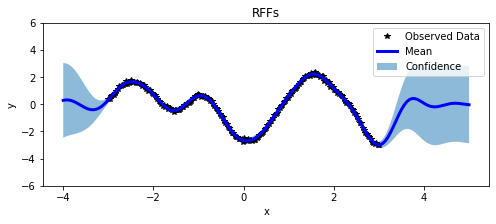

post training lengthscale
0.4588093161582947
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


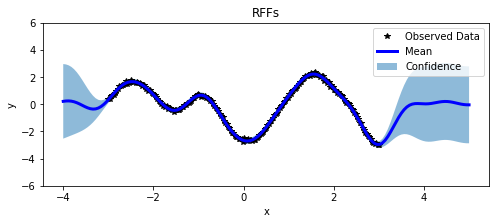

post training lengthscale
0.4593013823032379
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


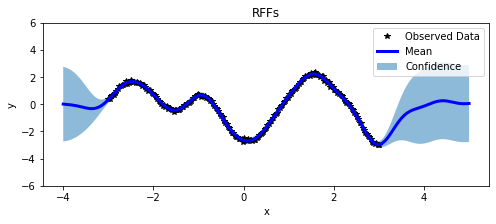

post training lengthscale
0.46684765815734863
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.8318928480148315 2.0
1.8318928480148315


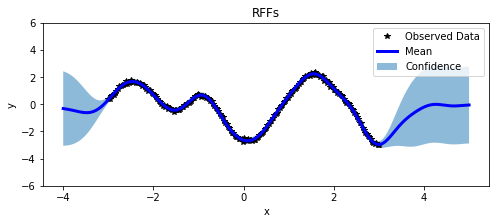

post training lengthscale
0.4643135368824005
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


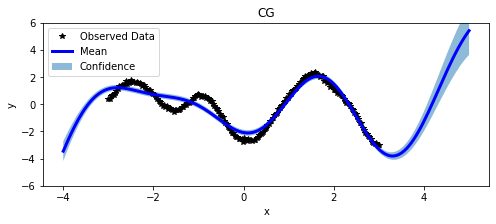

post training lengthscale = 1.66
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


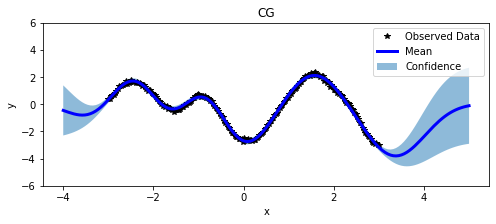

post training lengthscale = 0.84
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


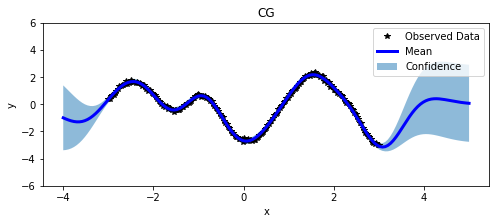

post training lengthscale = 0.64
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


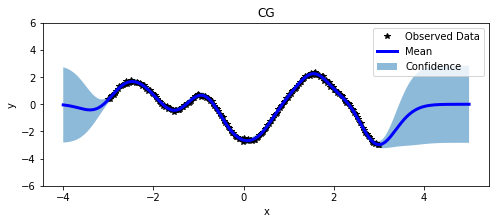

post training lengthscale = 0.46
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


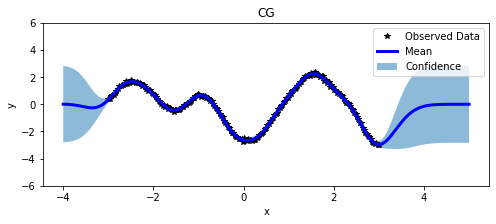

post training lengthscale = 0.41
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


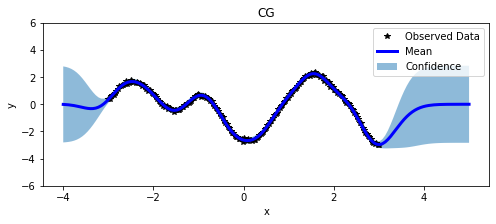

post training lengthscale = 0.43
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


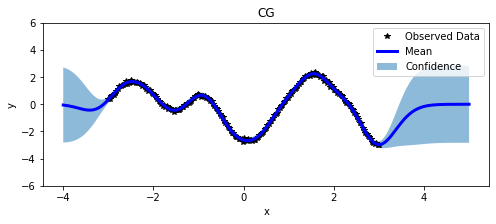

post training lengthscale = 0.46
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


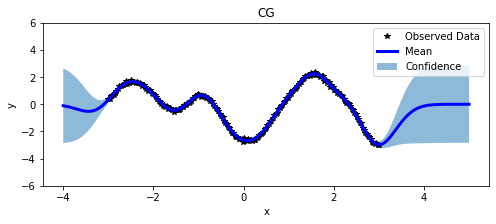

post training lengthscale = 0.48
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


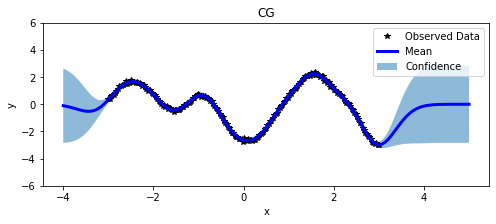

post training lengthscale = 0.48
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


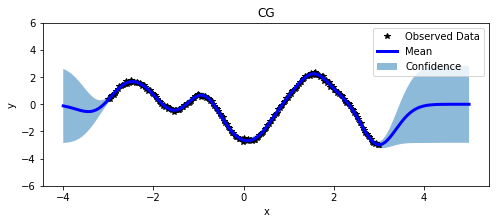

post training lengthscale = 0.49
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


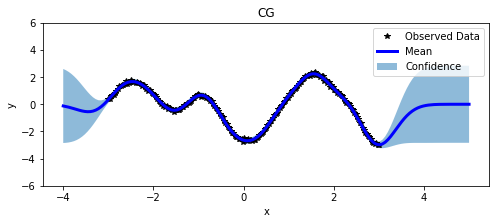

post training lengthscale = 0.49
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


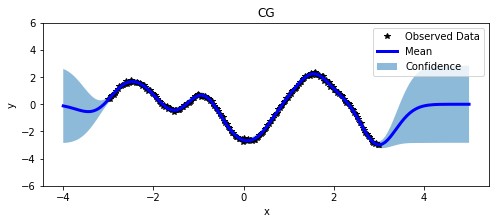

post training lengthscale = 0.49
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6791679859161377 2.0
0.4643135368824005


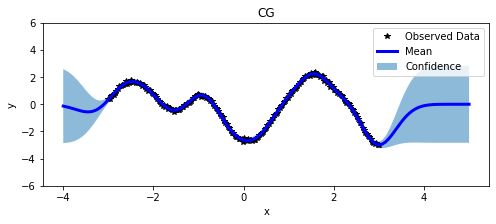

post training lengthscale = 0.49
true lengthscale= 0.67


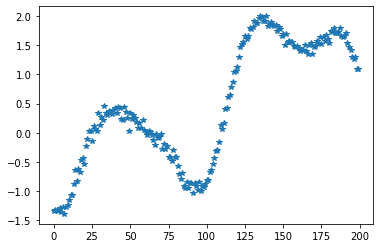

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


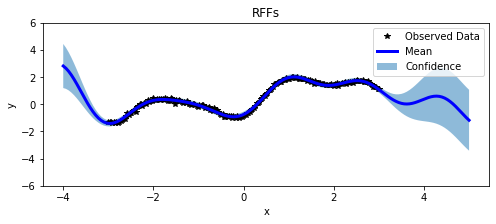

post training lengthscale
0.3798598647117615
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


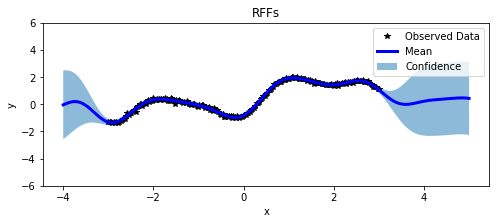

post training lengthscale
0.47769036889076233
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


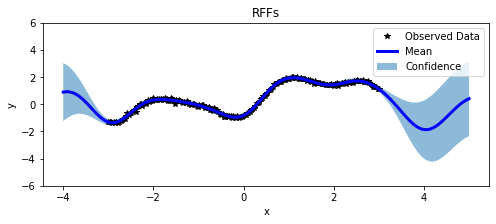

post training lengthscale
0.5237265229225159
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


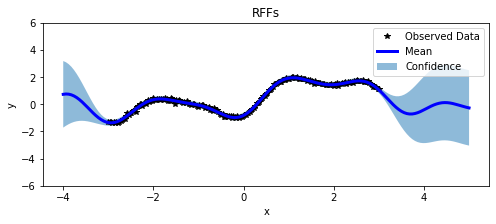

post training lengthscale
0.5706824660301208
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


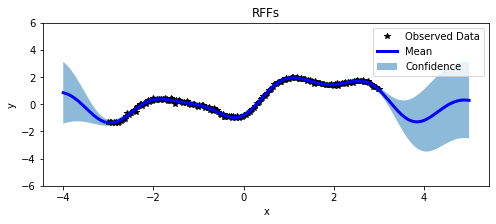

post training lengthscale
0.6137987375259399
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


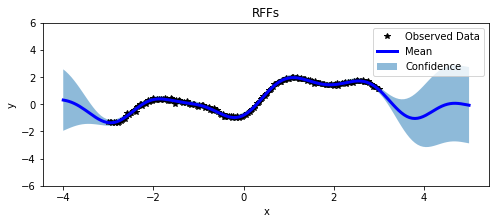

post training lengthscale
0.6079420447349548
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


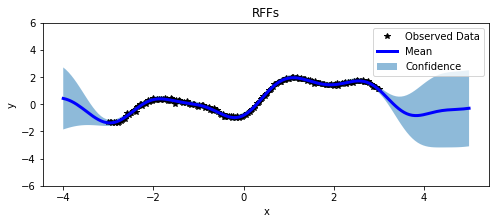

post training lengthscale
0.6388922333717346
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


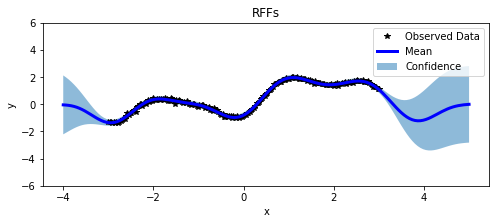

post training lengthscale
0.6534959077835083
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


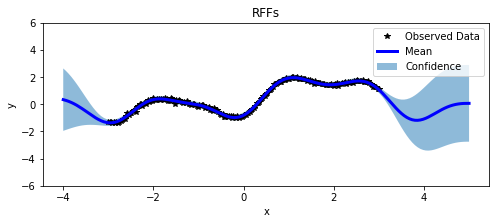

post training lengthscale
0.6449105143547058
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


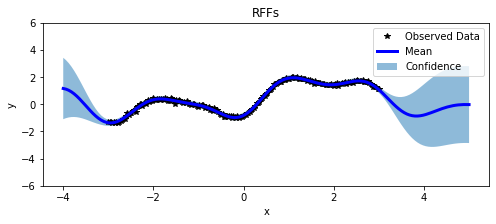

post training lengthscale
0.6672396063804626
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


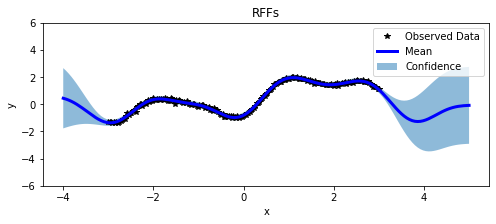

post training lengthscale
0.6521025896072388
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


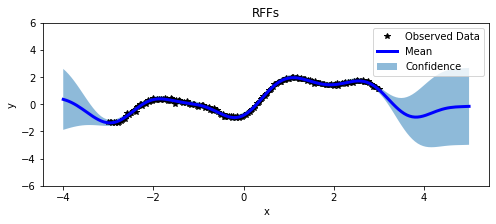

post training lengthscale
0.6501865983009338
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


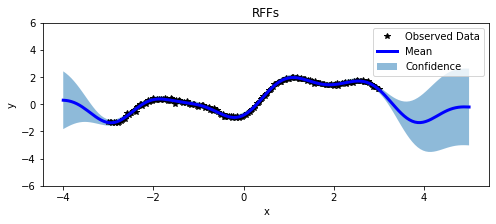

post training lengthscale
0.6787554621696472
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


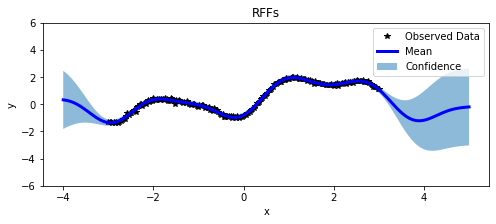

post training lengthscale
0.6736319065093994
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


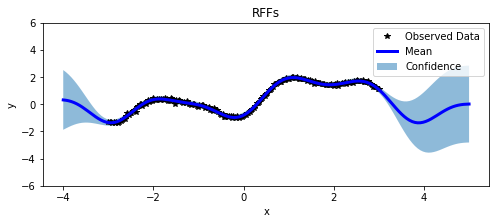

post training lengthscale
0.6696615815162659
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


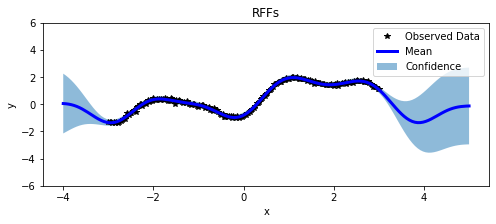

post training lengthscale
0.6739781498908997
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


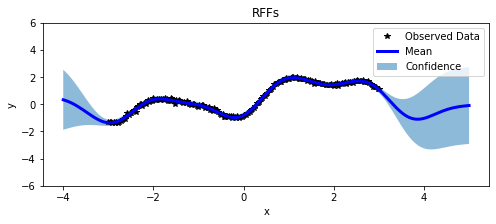

post training lengthscale
0.6782945394515991
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


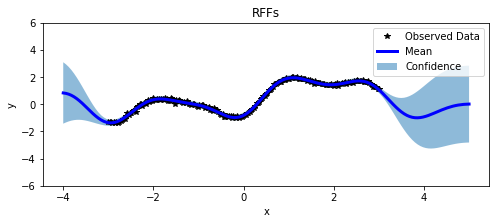

post training lengthscale
0.6692914962768555
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.7491421699523926 2.0
1.7491421699523926


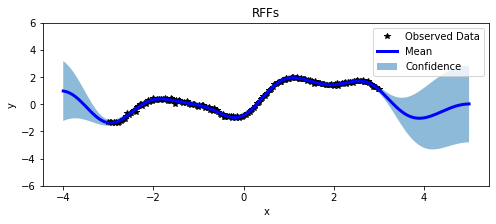

post training lengthscale
0.6851601600646973
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


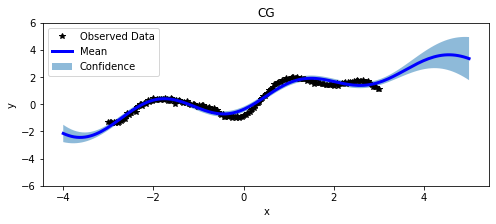

post training lengthscale = 1.82
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


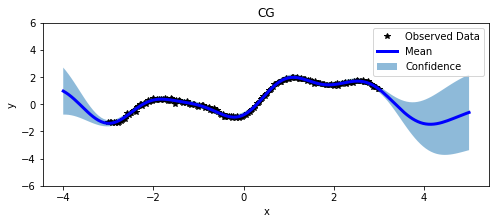

post training lengthscale = 0.88
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


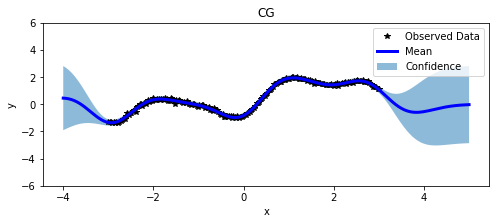

post training lengthscale = 0.65
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


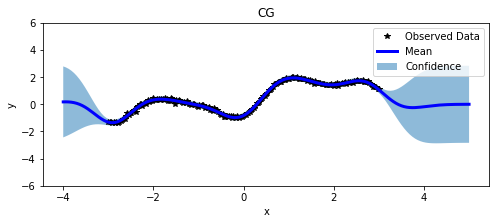

post training lengthscale = 0.55
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


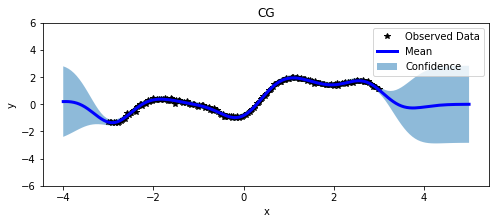

post training lengthscale = 0.55
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


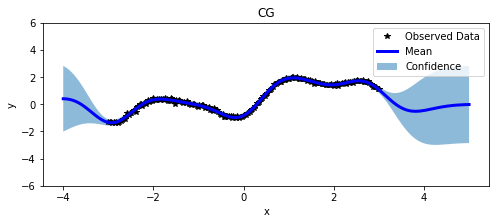

post training lengthscale = 0.63
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


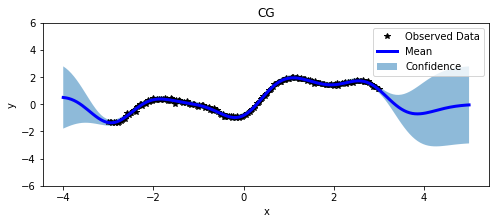

post training lengthscale = 0.67
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


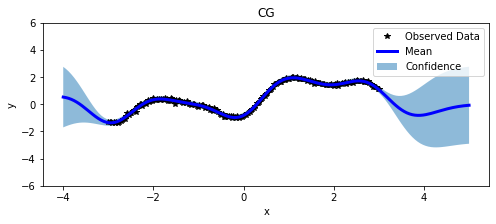

post training lengthscale = 0.69
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


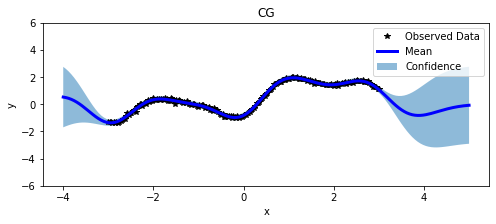

post training lengthscale = 0.69
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


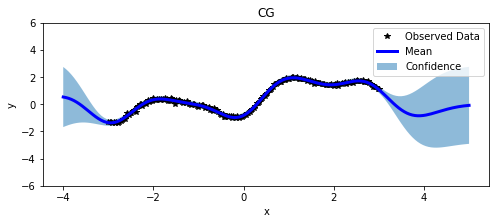

post training lengthscale = 0.70
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


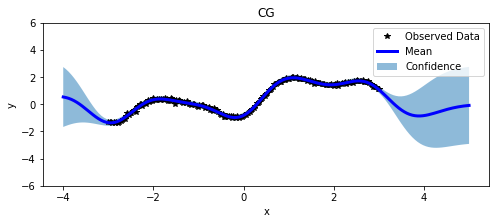

post training lengthscale = 0.70
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


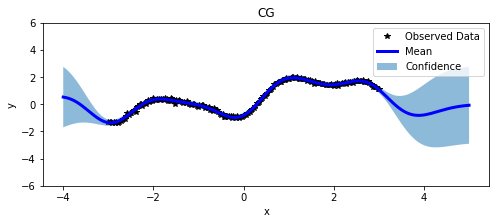

post training lengthscale = 0.69
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4416120052337646 2.0
0.6851601600646973


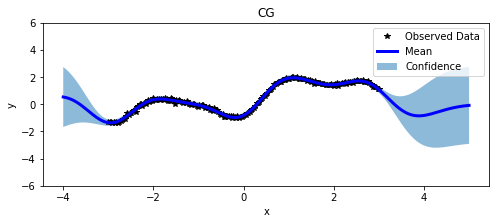

post training lengthscale = 0.70
true lengthscale= 0.86


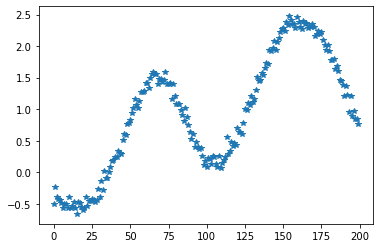

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


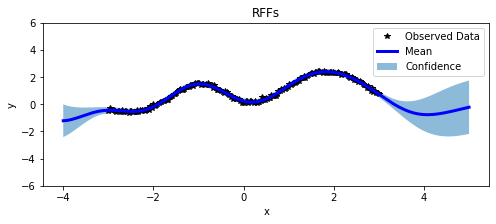

post training lengthscale
0.4376870393753052
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


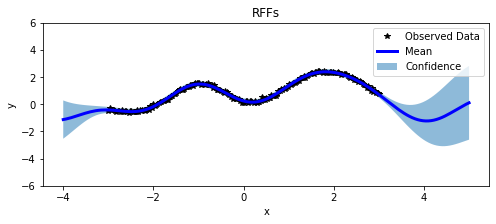

post training lengthscale
0.7058499455451965
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


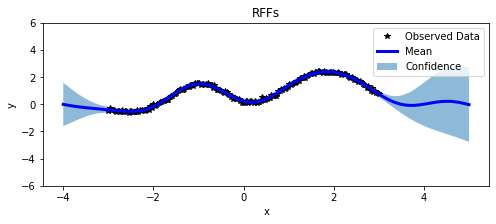

post training lengthscale
0.7613378763198853
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


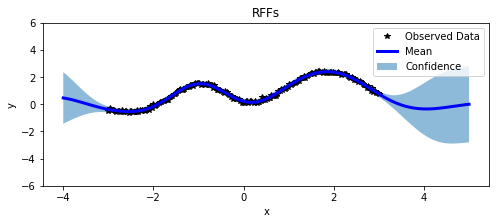

post training lengthscale
0.8258058428764343
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


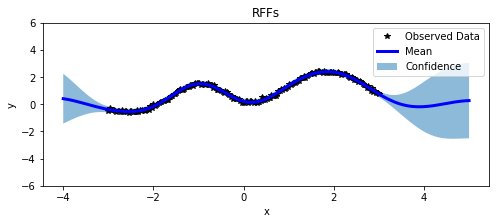

post training lengthscale
0.8361846208572388
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


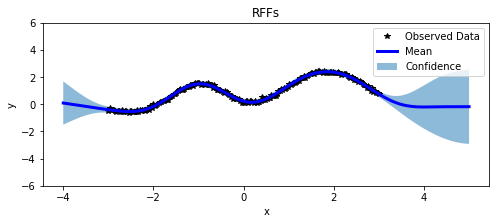

post training lengthscale
0.8591431379318237
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


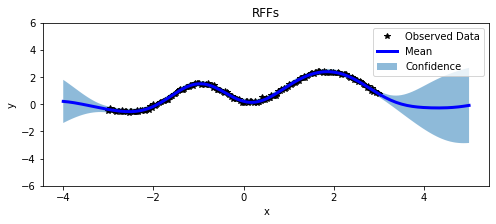

post training lengthscale
0.8968207240104675
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


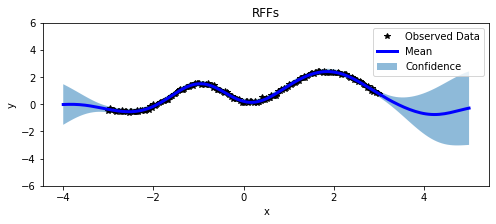

post training lengthscale
0.8979194164276123
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


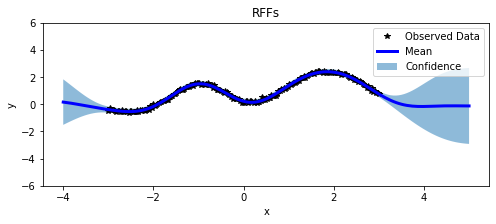

post training lengthscale
0.863563060760498
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


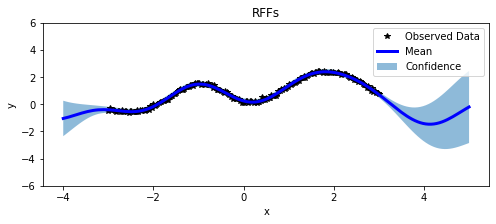

post training lengthscale
0.9256066083908081
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


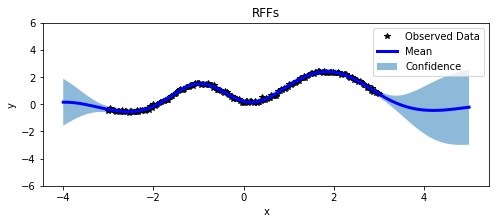

post training lengthscale
0.8956462144851685
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


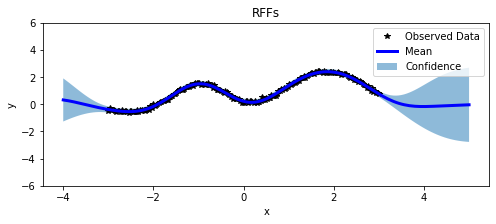

post training lengthscale
0.9237035512924194
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


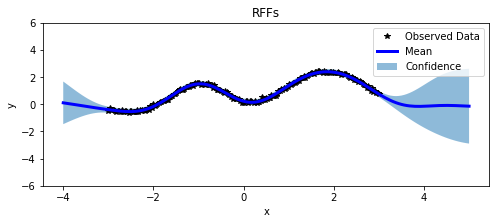

post training lengthscale
0.916464626789093
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


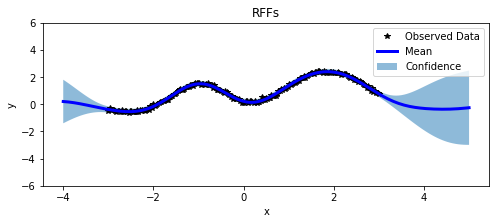

post training lengthscale
0.9476973414421082
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


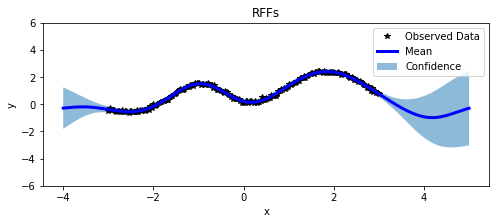

post training lengthscale
0.9144707322120667
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


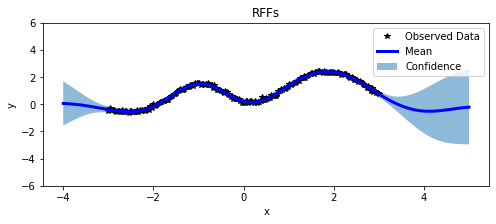

post training lengthscale
0.9216030836105347
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


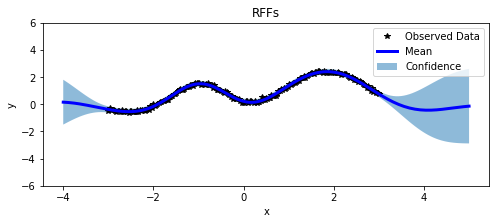

post training lengthscale
0.9370973110198975
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


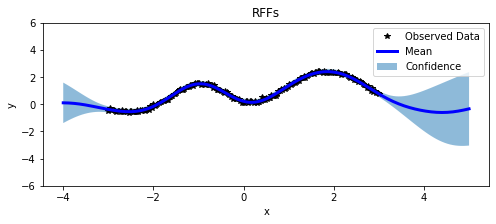

post training lengthscale
0.945372462272644
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4158965349197388 2.0
1.4158965349197388


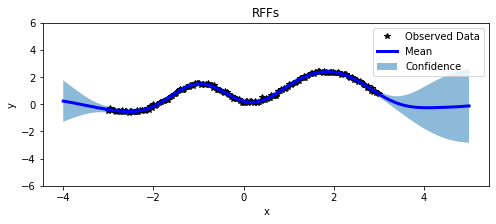

post training lengthscale
0.9602419137954712
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


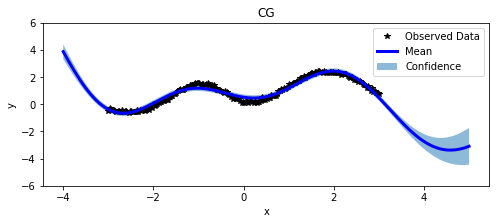

post training lengthscale = 2.05
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


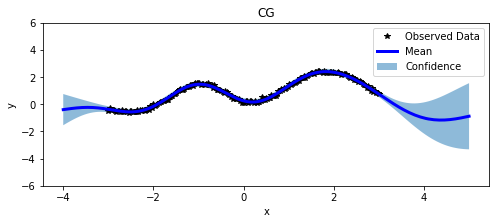

post training lengthscale = 1.21
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


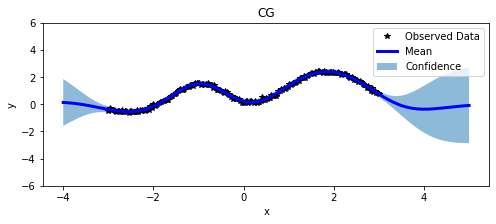

post training lengthscale = 0.89
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


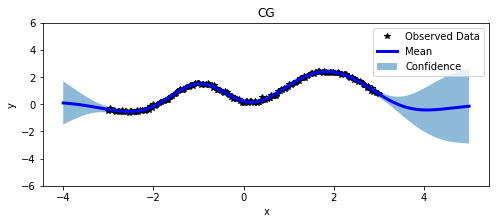

post training lengthscale = 0.95
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


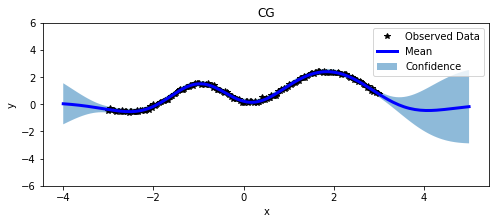

post training lengthscale = 0.98
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


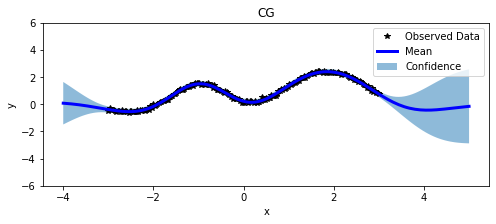

post training lengthscale = 0.96
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


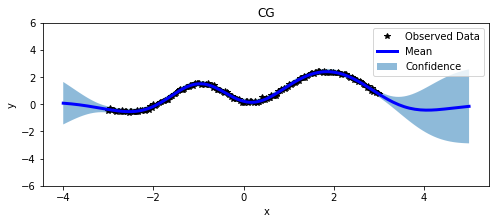

post training lengthscale = 0.96
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


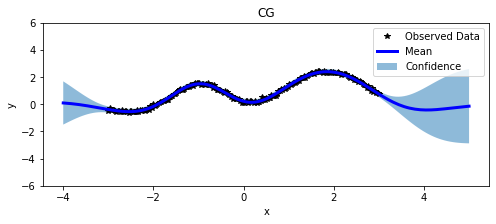

post training lengthscale = 0.95
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


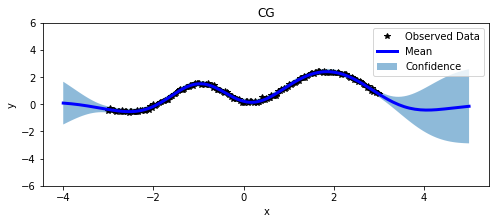

post training lengthscale = 0.95
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


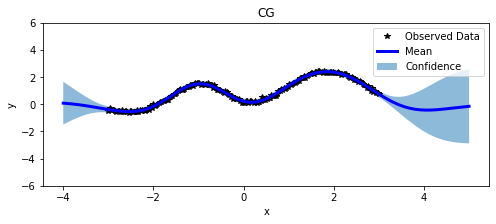

post training lengthscale = 0.96
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


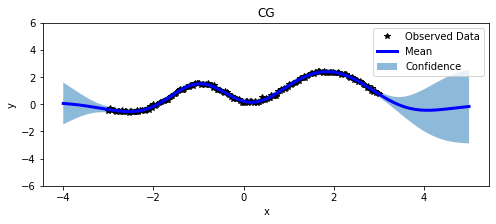

post training lengthscale = 0.97
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


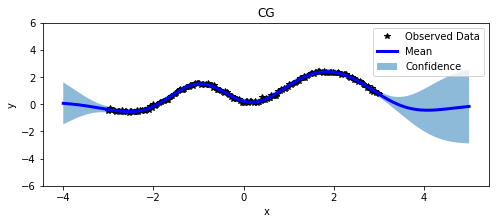

post training lengthscale = 0.97
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0148086547851562 2.0
0.9602419137954712


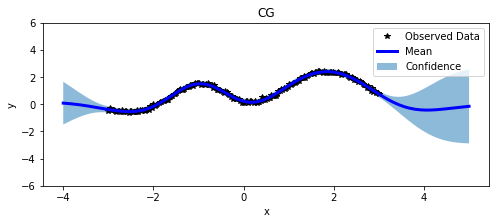

post training lengthscale = 0.96
true lengthscale= 1.05


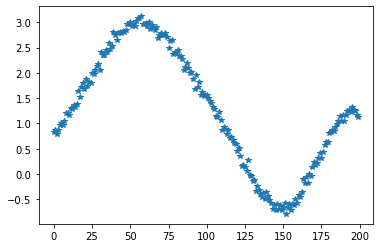

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


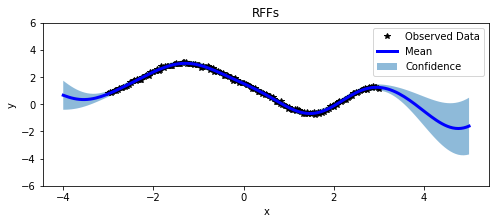

post training lengthscale
0.4993983209133148
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


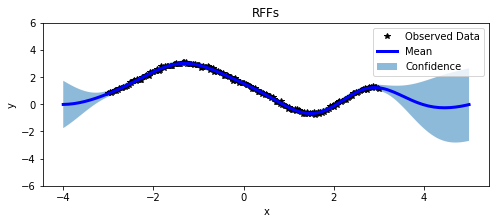

post training lengthscale
0.723469614982605
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


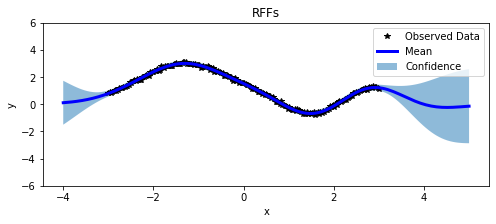

post training lengthscale
0.7961195111274719
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


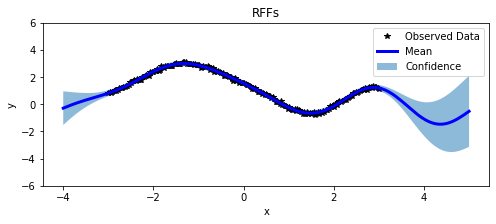

post training lengthscale
0.88421231508255
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


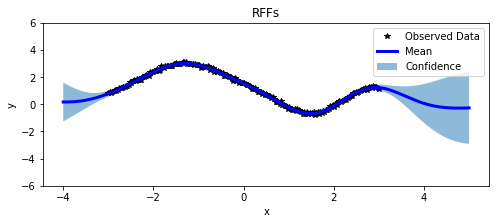

post training lengthscale
0.9939025640487671
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


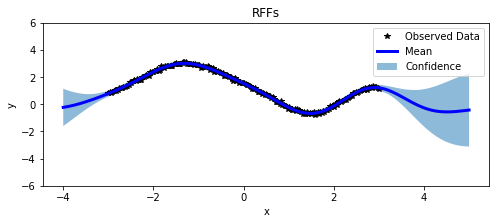

post training lengthscale
0.9617424607276917
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


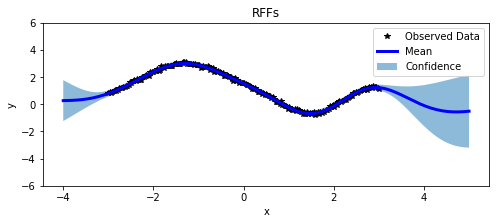

post training lengthscale
0.9305660724639893
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


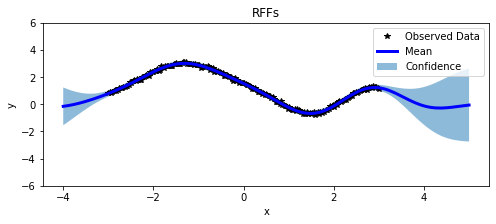

post training lengthscale
0.9778462648391724
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


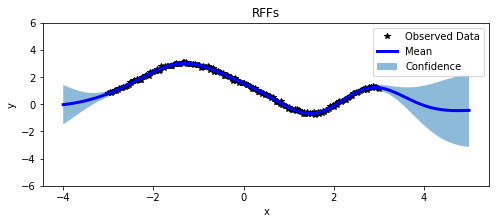

post training lengthscale
0.9965063333511353
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


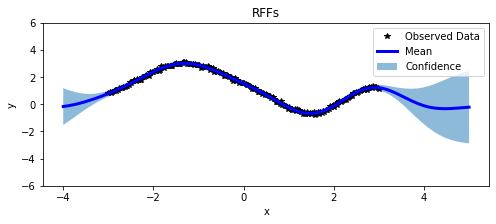

post training lengthscale
1.0103485584259033
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


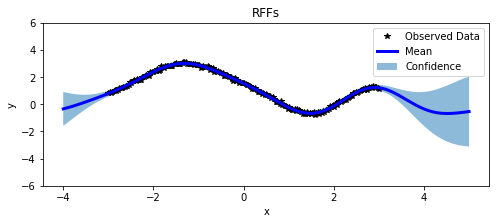

post training lengthscale
1.0511943101882935
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


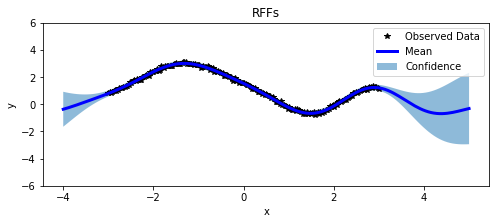

post training lengthscale
1.0534588098526
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


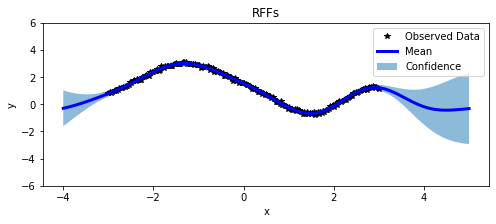

post training lengthscale
1.0394262075424194
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


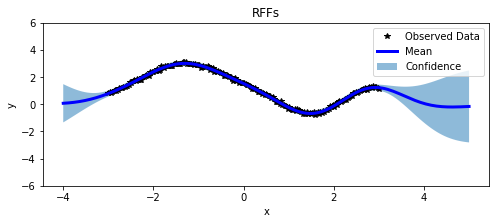

post training lengthscale
1.0333037376403809
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


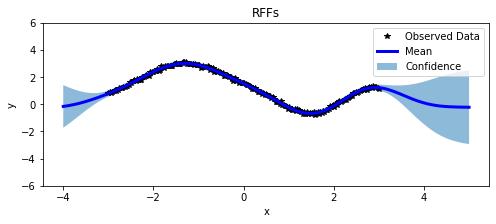

post training lengthscale
0.9817421436309814
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


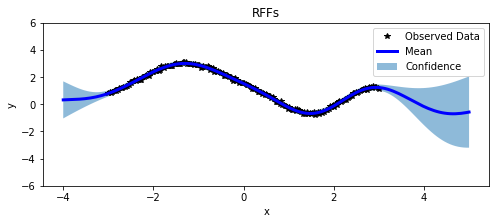

post training lengthscale
1.0535402297973633
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


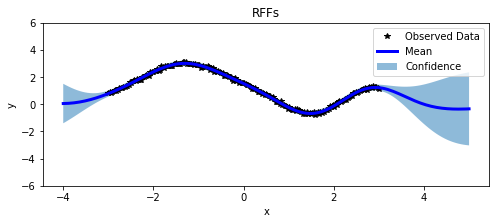

post training lengthscale
0.973781943321228
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


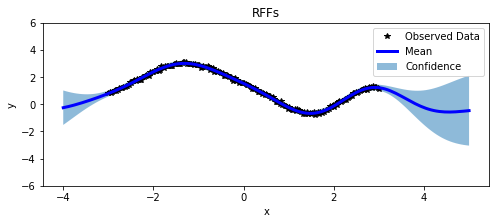

post training lengthscale
1.0895075798034668
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7952505350112915 2.0
0.7952505350112915


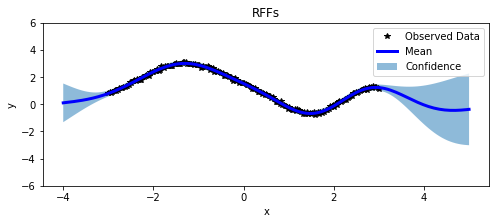

post training lengthscale
1.0654194355010986
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


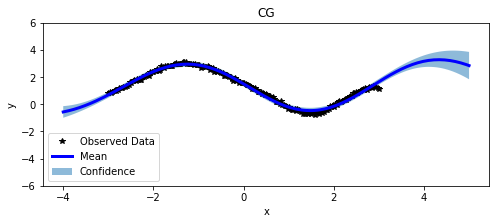

post training lengthscale = 2.51
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


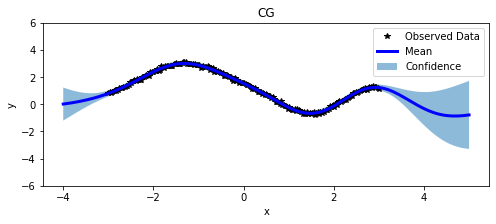

post training lengthscale = 1.16
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


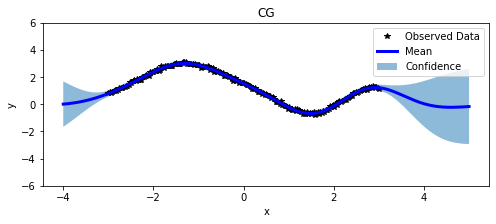

post training lengthscale = 0.91
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


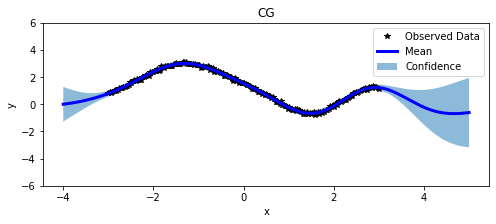

post training lengthscale = 1.12
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


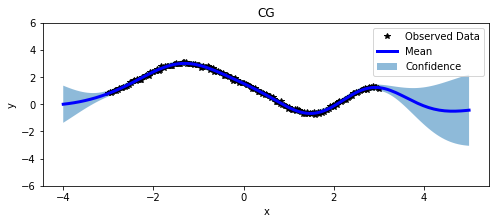

post training lengthscale = 1.06
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


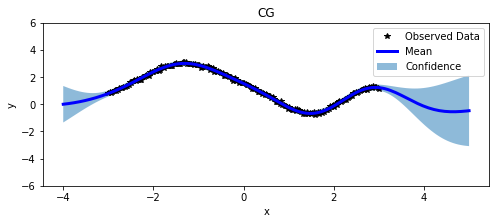

post training lengthscale = 1.08
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


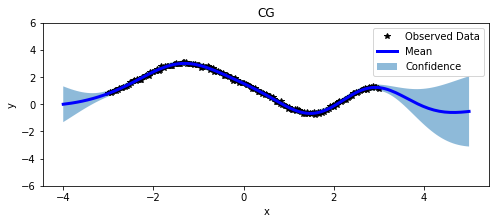

post training lengthscale = 1.09
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


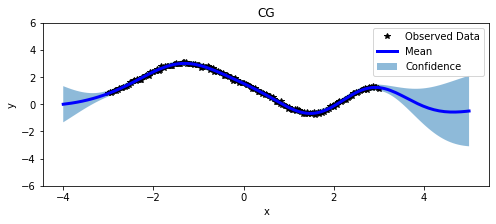

post training lengthscale = 1.08
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


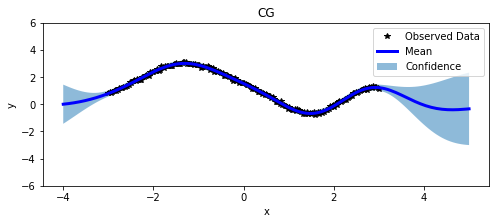

post training lengthscale = 1.02
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


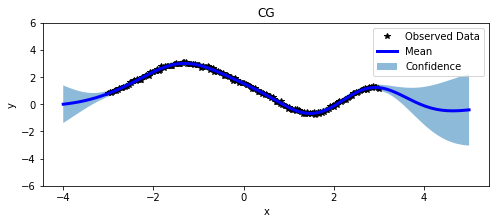

post training lengthscale = 1.05
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


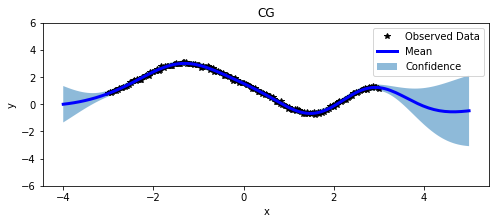

post training lengthscale = 1.08
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


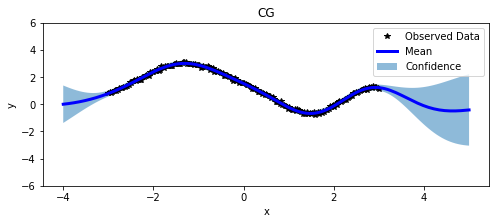

post training lengthscale = 1.06
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.674431562423706 2.0
1.0654194355010986


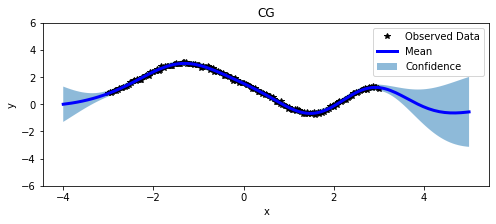

post training lengthscale = 1.10
true lengthscale= 1.24


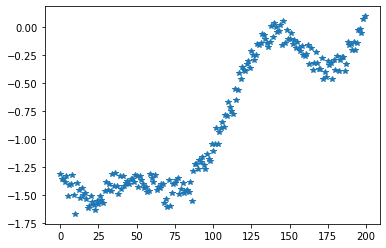

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


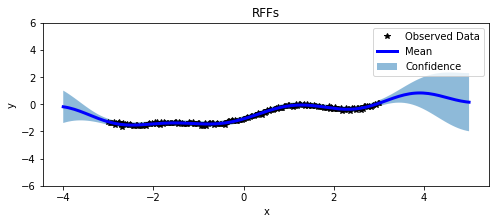

post training lengthscale
0.6107500195503235
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


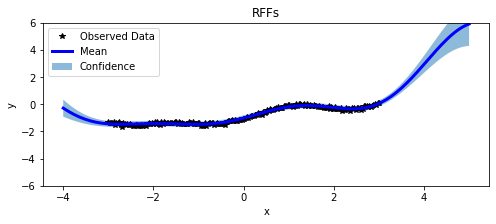

post training lengthscale
1.0621949434280396
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


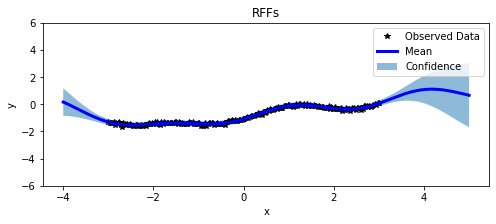

post training lengthscale
1.2124245166778564
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


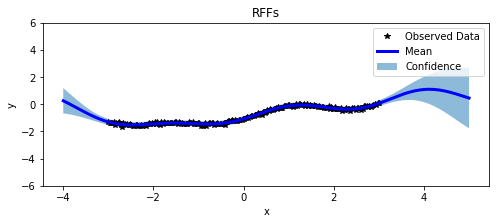

post training lengthscale
1.1632914543151855
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


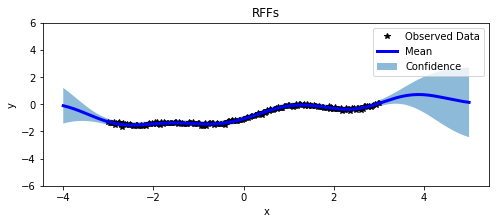

post training lengthscale
1.2345482110977173
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


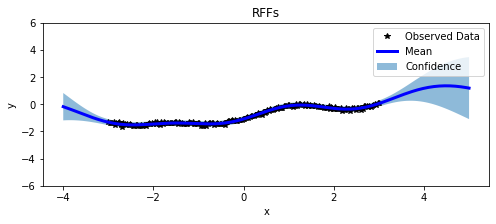

post training lengthscale
1.2536976337432861
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


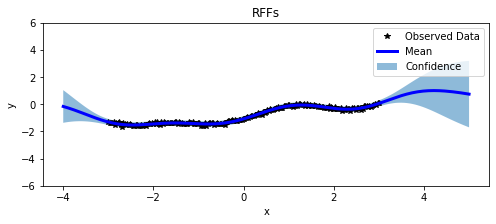

post training lengthscale
1.189596176147461
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


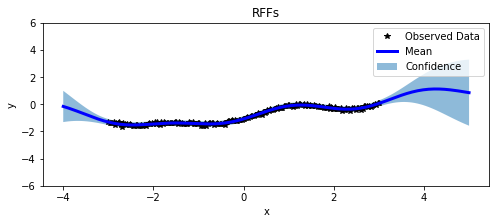

post training lengthscale
1.2701995372772217
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


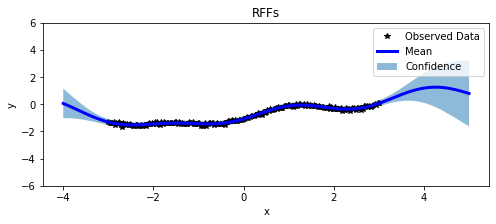

post training lengthscale
1.2145707607269287
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


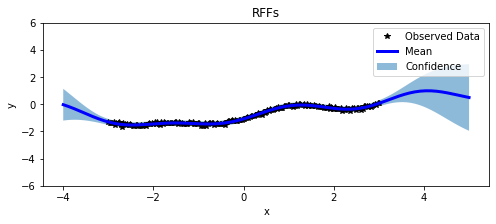

post training lengthscale
1.1804777383804321
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


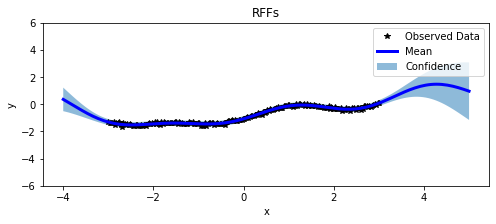

post training lengthscale
1.2526129484176636
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


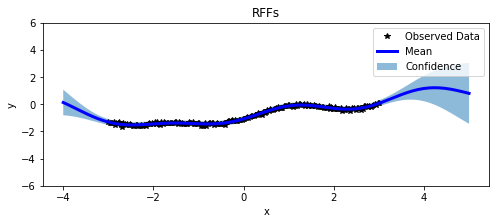

post training lengthscale
1.2906877994537354
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


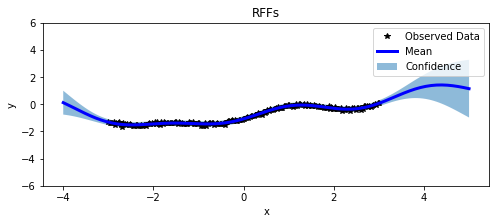

post training lengthscale
1.29924476146698
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


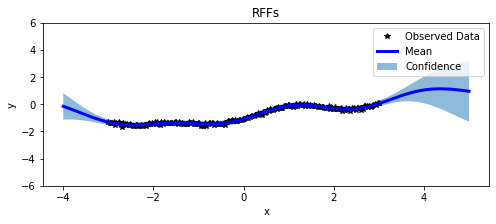

post training lengthscale
1.3377026319503784
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


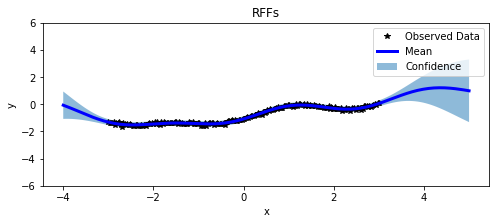

post training lengthscale
1.2488058805465698
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


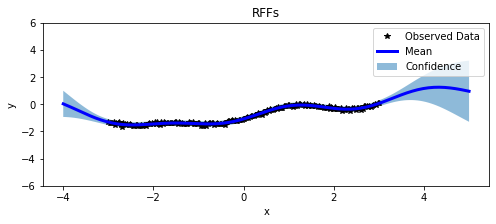

post training lengthscale
1.3217321634292603
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


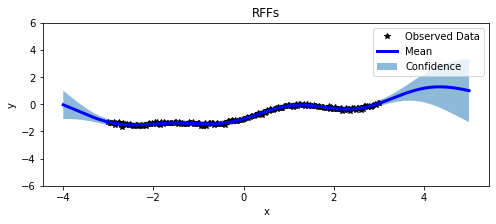

post training lengthscale
1.2815607786178589
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


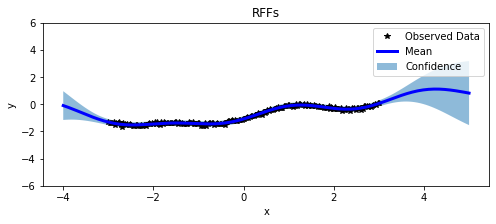

post training lengthscale
1.290092945098877
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.0688225030899048 2.0
1.0688225030899048


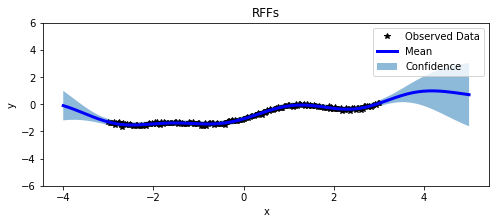

post training lengthscale
1.2768751382827759
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


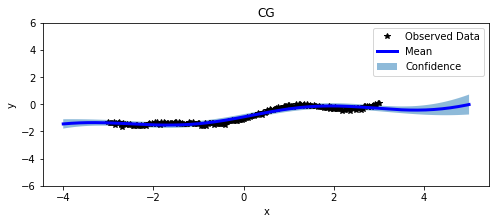

post training lengthscale = 3.11
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


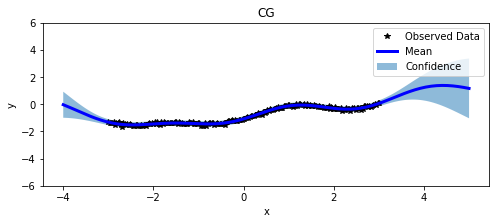

post training lengthscale = 1.37
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


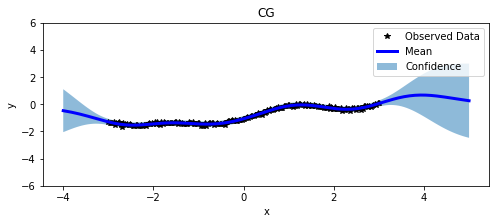

post training lengthscale = 0.95
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


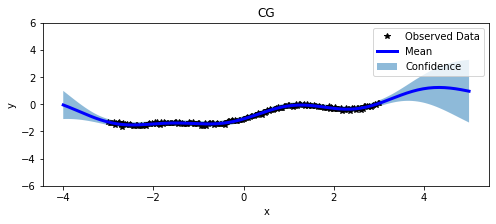

post training lengthscale = 1.30
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


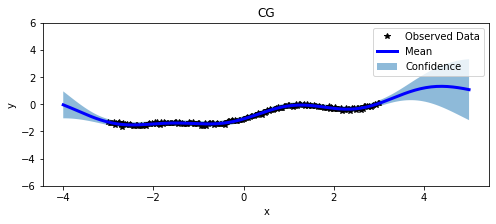

post training lengthscale = 1.34
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


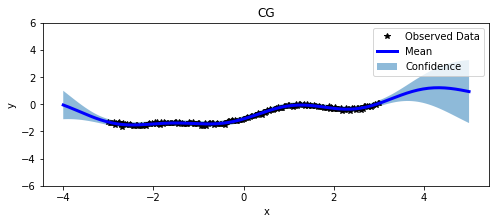

post training lengthscale = 1.29
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


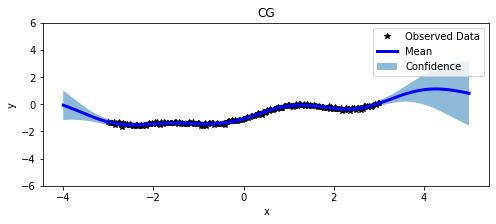

post training lengthscale = 1.25
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


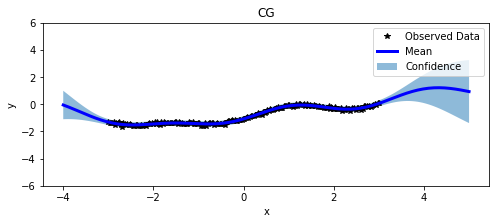

post training lengthscale = 1.29
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


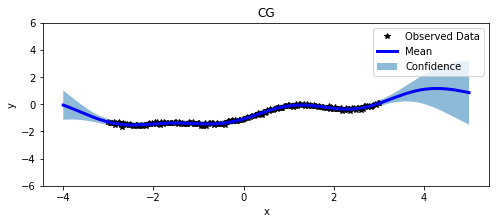

post training lengthscale = 1.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


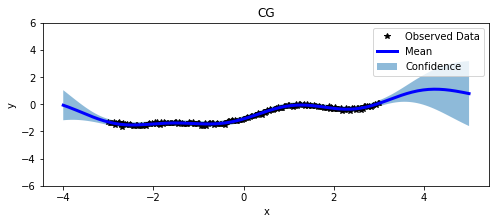

post training lengthscale = 1.24
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


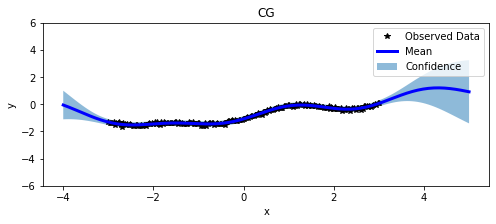

post training lengthscale = 1.28
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


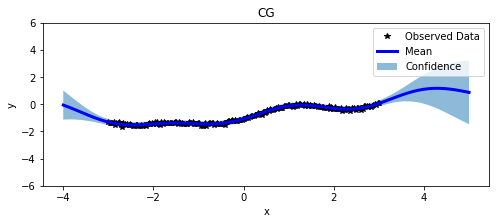

post training lengthscale = 1.27
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.4799783527851105 2.0
1.2768751382827759


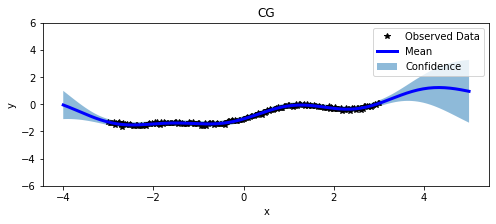

post training lengthscale = 1.29
true lengthscale= 1.43


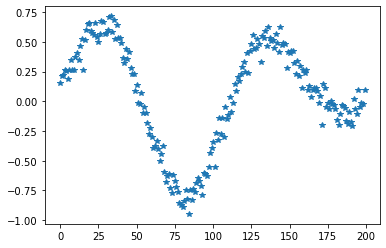

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


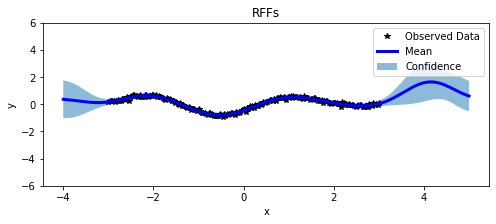

post training lengthscale
0.47897687554359436
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


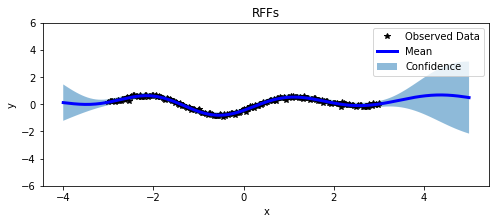

post training lengthscale
0.8008305430412292
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


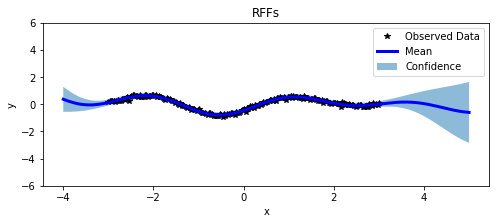

post training lengthscale
1.0609569549560547
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


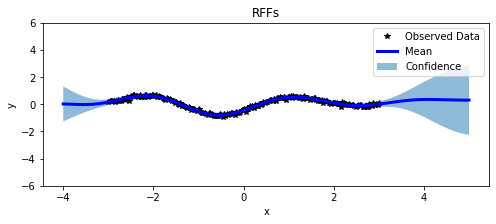

post training lengthscale
1.0984742641448975
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


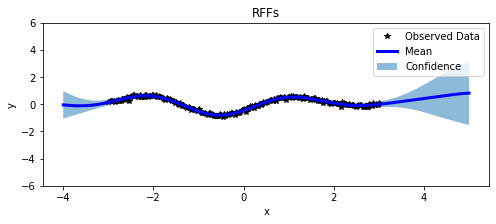

post training lengthscale
1.1462599039077759
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


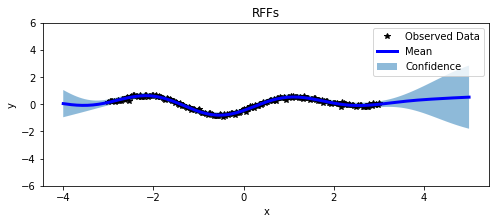

post training lengthscale
1.2189340591430664
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


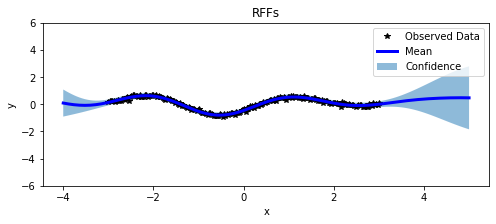

post training lengthscale
1.185020923614502
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


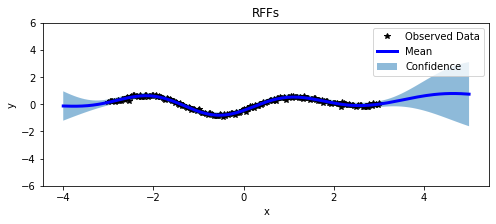

post training lengthscale
1.2362217903137207
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


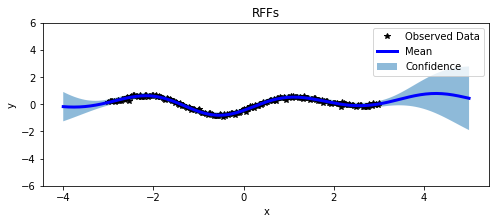

post training lengthscale
1.2428241968154907
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


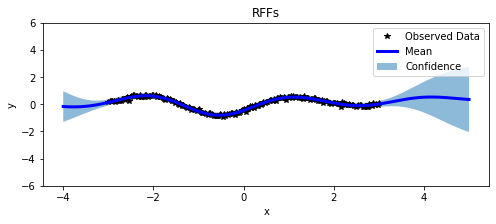

post training lengthscale
1.2324893474578857
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


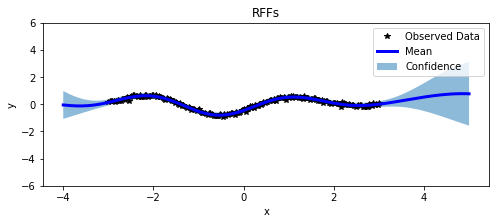

post training lengthscale
1.1749663352966309
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


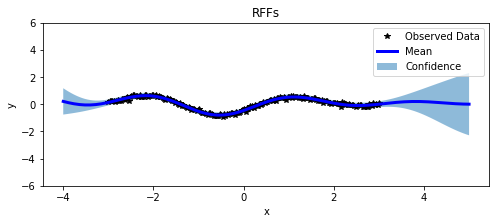

post training lengthscale
1.210737943649292
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


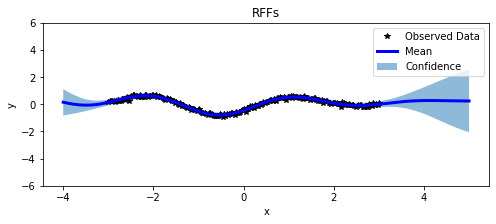

post training lengthscale
1.2232170104980469
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


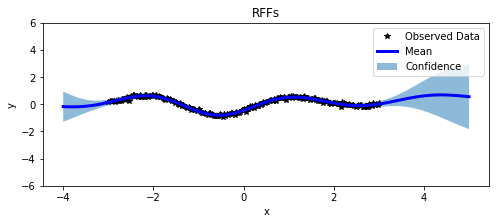

post training lengthscale
1.2318222522735596
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


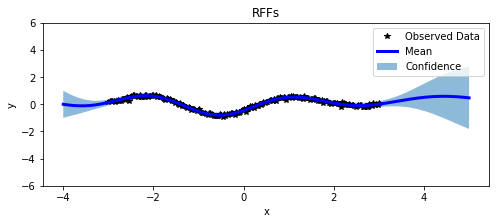

post training lengthscale
1.2519748210906982
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


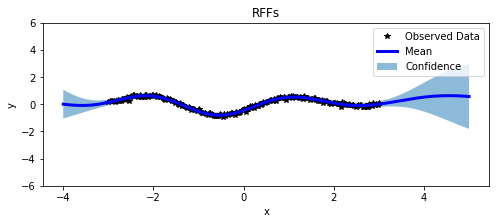

post training lengthscale
1.2157082557678223
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


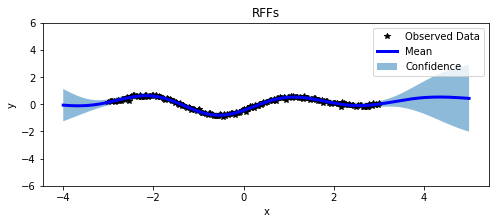

post training lengthscale
1.2227622270584106
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


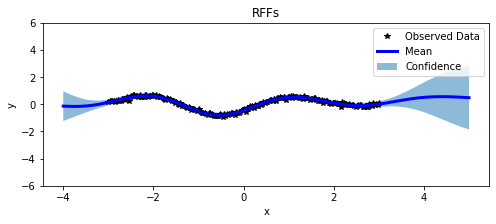

post training lengthscale
1.2385878562927246
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.2967550754547119 2.0
0.2967550754547119


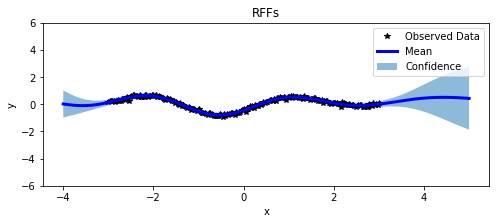

post training lengthscale
1.2467873096466064
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


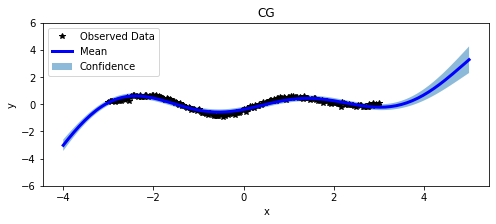

post training lengthscale = 2.56
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


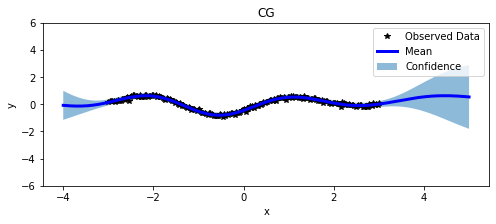

post training lengthscale = 1.27
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


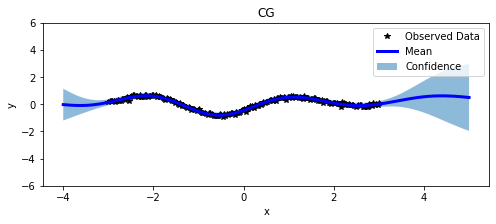

post training lengthscale = 1.19
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


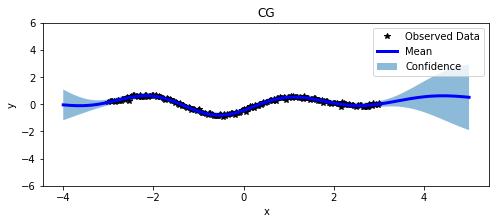

post training lengthscale = 1.22
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


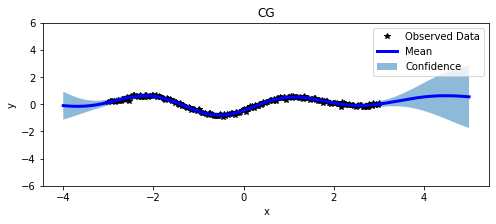

post training lengthscale = 1.30
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


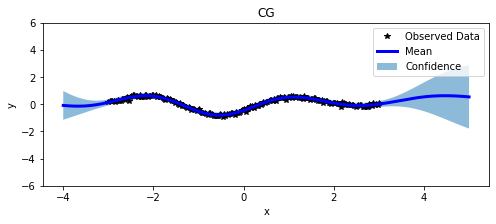

post training lengthscale = 1.28
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


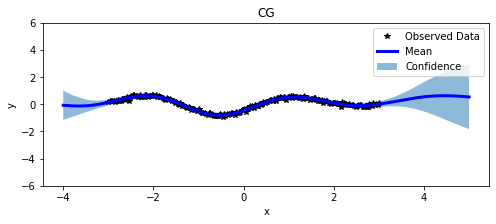

post training lengthscale = 1.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


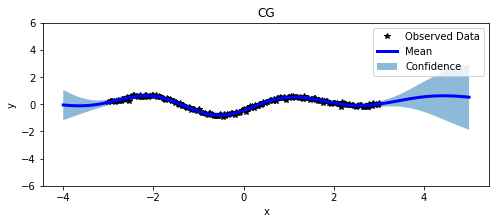

post training lengthscale = 1.23
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


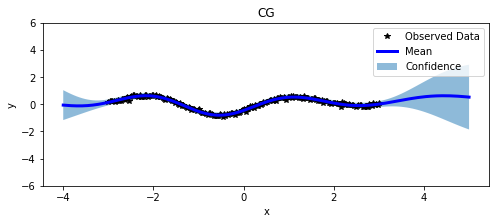

post training lengthscale = 1.24
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


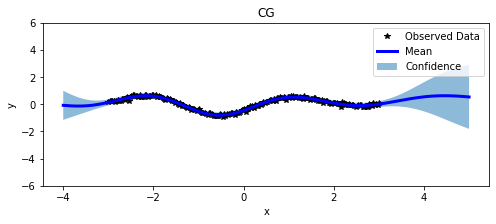

post training lengthscale = 1.27
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


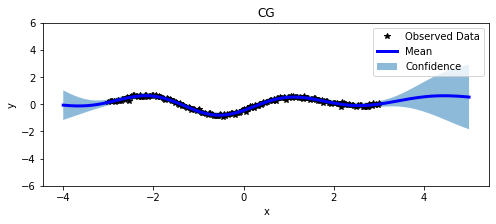

post training lengthscale = 1.25
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


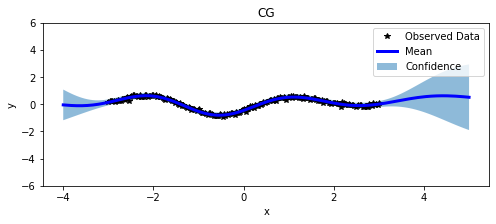

post training lengthscale = 1.22
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.6940439939498901 2.0
1.2467873096466064


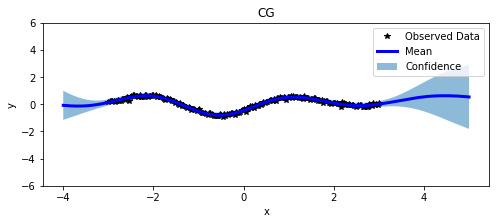

post training lengthscale = 1.27
true lengthscale= 1.62


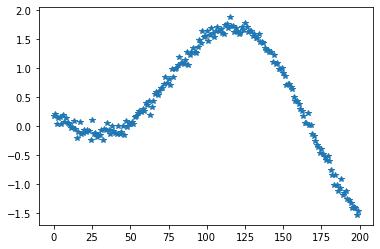

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


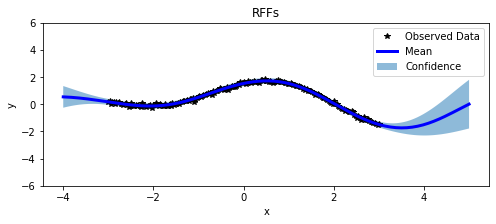

post training lengthscale
0.9113121628761292
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


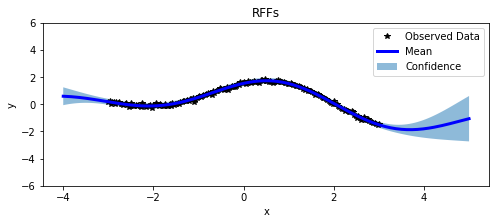

post training lengthscale
1.5233525037765503
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


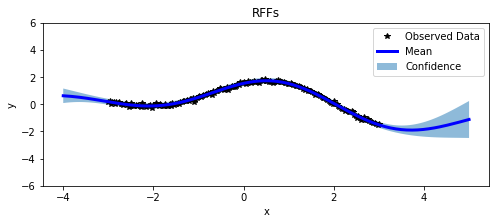

post training lengthscale
1.7058779001235962
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


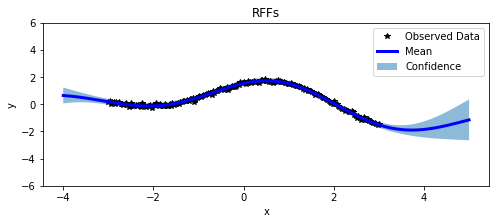

post training lengthscale
1.6826844215393066
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


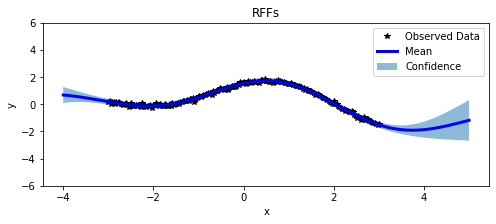

post training lengthscale
1.8287432193756104
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


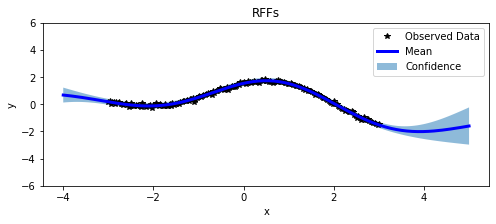

post training lengthscale
1.8742260932922363
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


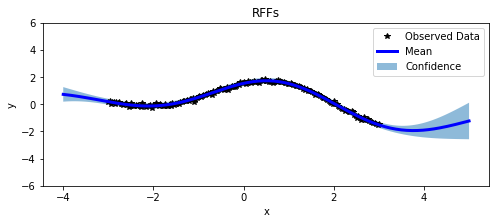

post training lengthscale
1.8253854513168335
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


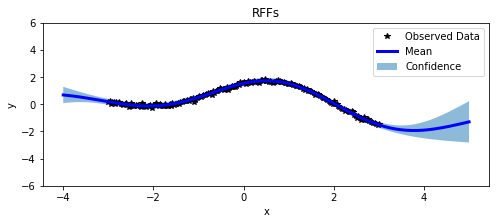

post training lengthscale
1.7750831842422485
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


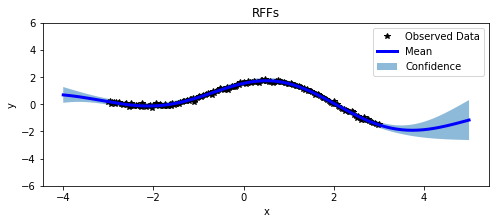

post training lengthscale
1.844419240951538
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


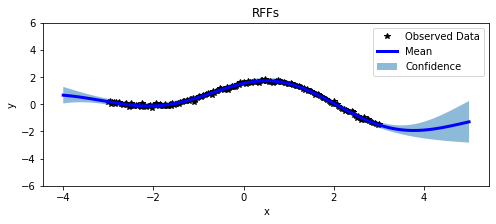

post training lengthscale
1.8538981676101685
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


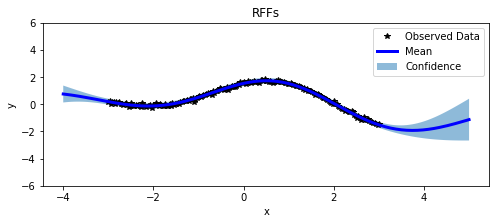

post training lengthscale
1.8677726984024048
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


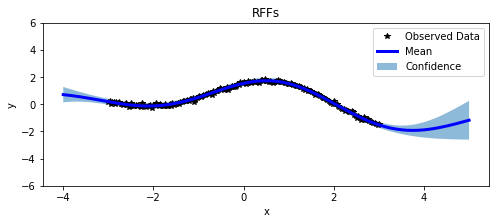

post training lengthscale
1.7565882205963135
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


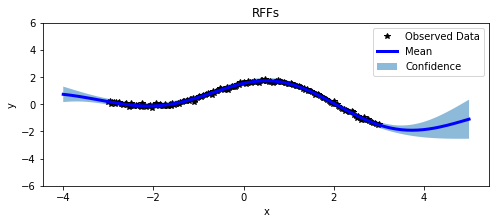

post training lengthscale
1.9007675647735596
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


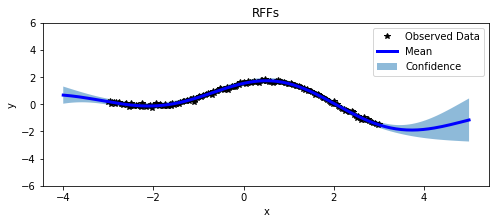

post training lengthscale
1.8270188570022583
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


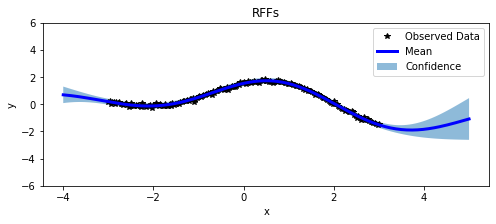

post training lengthscale
1.7762852907180786
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


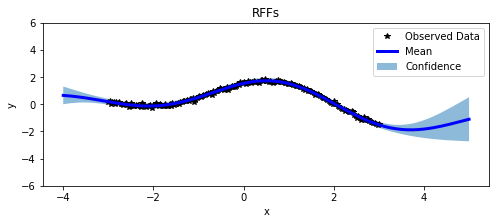

post training lengthscale
1.8453224897384644
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


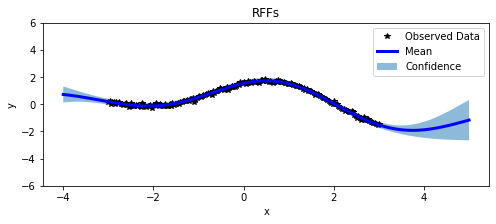

post training lengthscale
1.8349369764328003
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


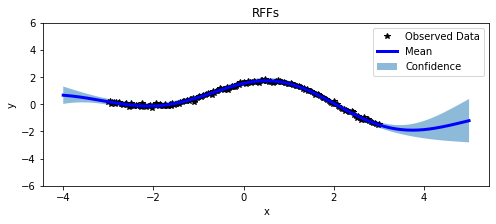

post training lengthscale
1.8675473928451538
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.1343069076538086 2.0
1.1343069076538086


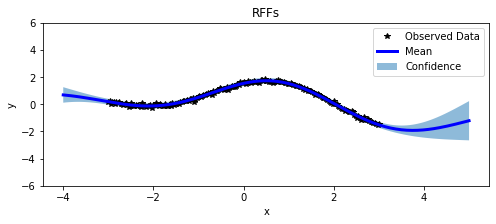

post training lengthscale
1.8475968837738037
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


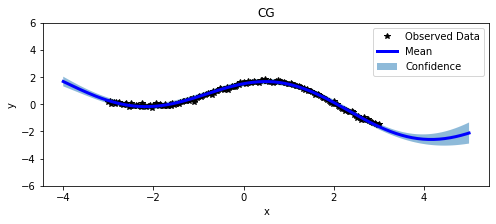

post training lengthscale = 3.00
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


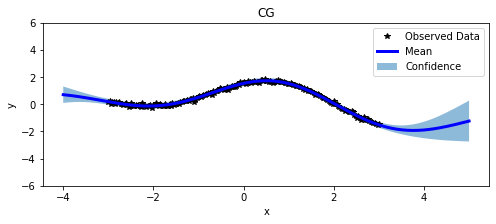

post training lengthscale = 1.90
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


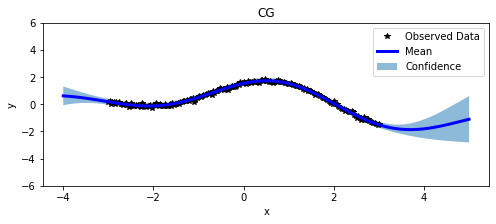

post training lengthscale = 1.72
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


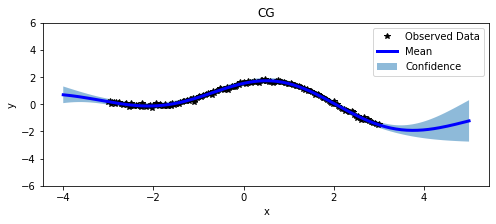

post training lengthscale = 1.88
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


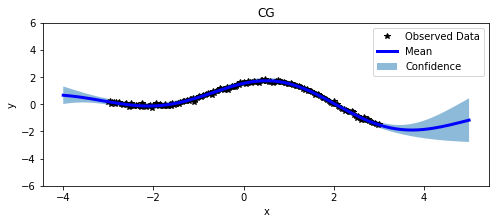

post training lengthscale = 1.81
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


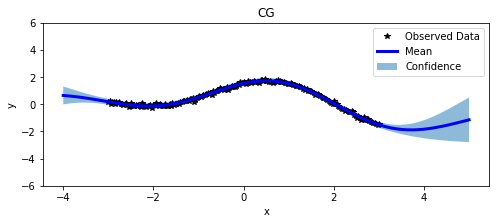

post training lengthscale = 1.78
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


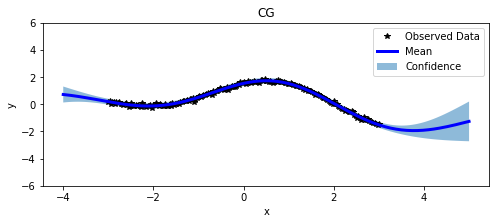

post training lengthscale = 1.94
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


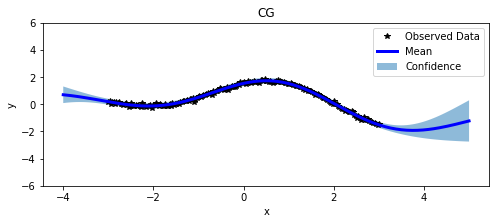

post training lengthscale = 1.88
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


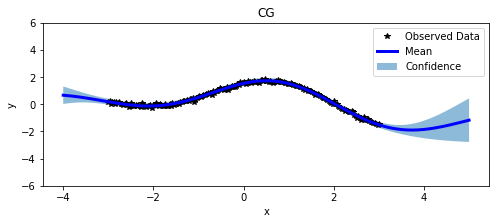

post training lengthscale = 1.81
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


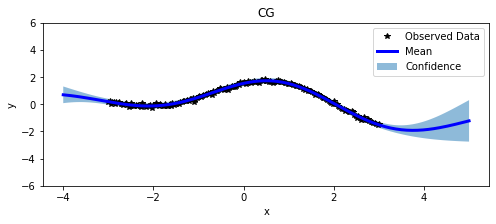

post training lengthscale = 1.88
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


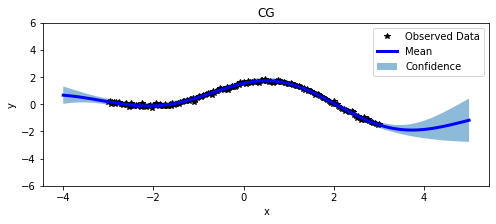

post training lengthscale = 1.81
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


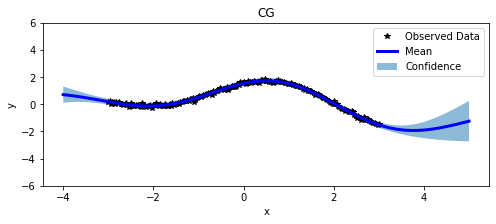

post training lengthscale = 1.91
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.4636896848678589 2.0
1.8475968837738037


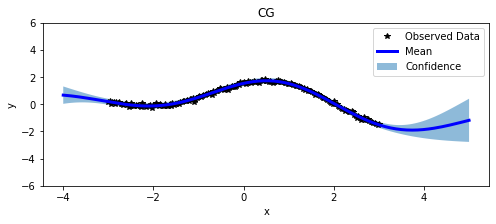

post training lengthscale = 1.82
true lengthscale= 1.81


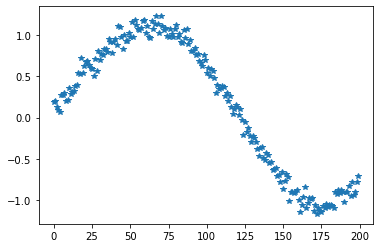

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


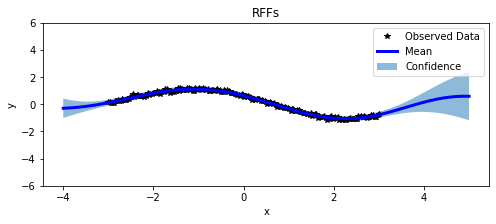

post training lengthscale
1.2290055751800537
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


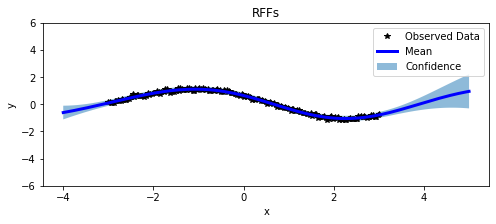

post training lengthscale
1.8389371633529663
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


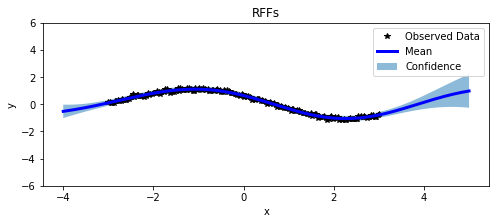

post training lengthscale
2.0130326747894287
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


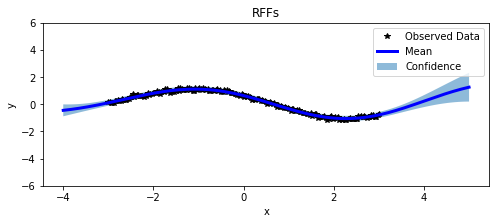

post training lengthscale
2.2032363414764404
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


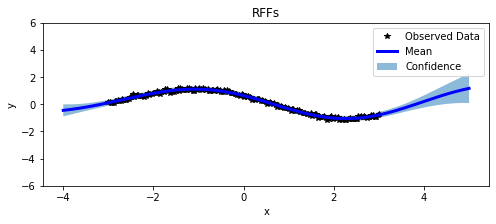

post training lengthscale
2.1830735206604004
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


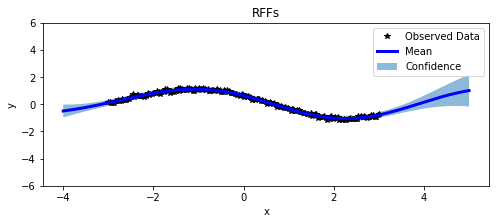

post training lengthscale
2.125491142272949
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


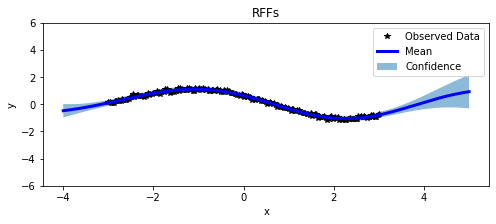

post training lengthscale
2.2179219722747803
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


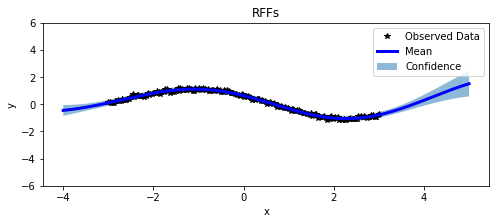

post training lengthscale
2.176704168319702
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


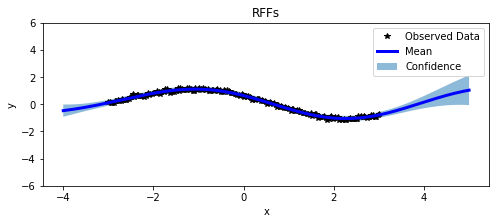

post training lengthscale
2.1895945072174072
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


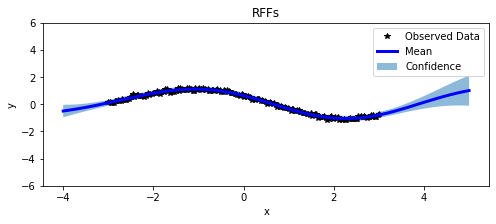

post training lengthscale
2.2708237171173096
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


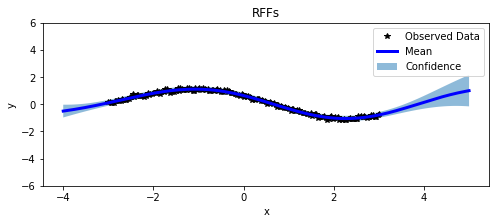

post training lengthscale
2.252963066101074
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


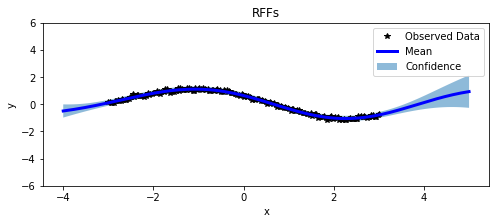

post training lengthscale
2.240910530090332
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


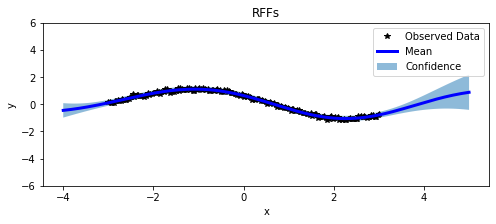

post training lengthscale
2.268144369125366
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


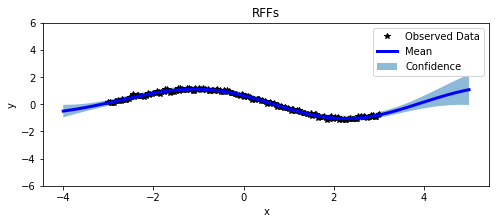

post training lengthscale
2.249803066253662
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


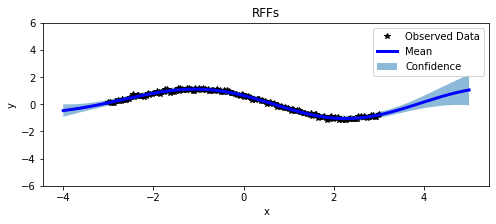

post training lengthscale
2.2242000102996826
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


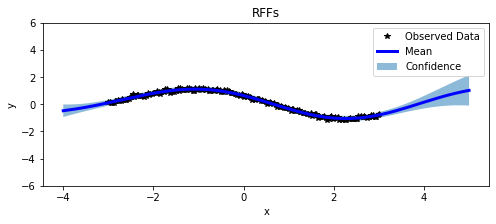

post training lengthscale
2.2185909748077393
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


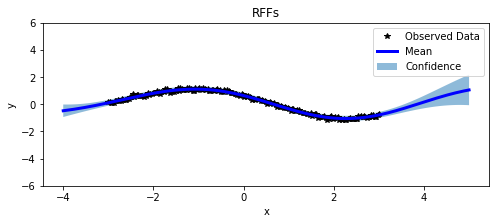

post training lengthscale
2.2554094791412354
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


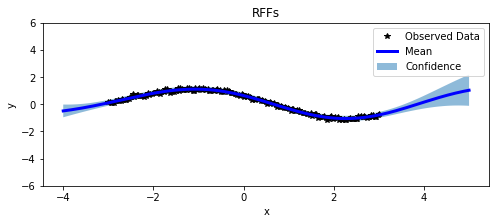

post training lengthscale
2.2407567501068115
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7986180782318115 2.0
0.7986180782318115


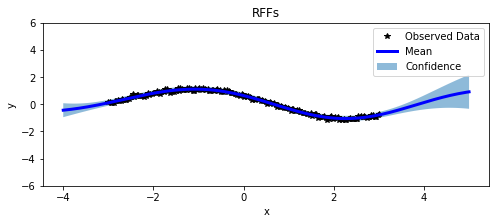

post training lengthscale
2.2514867782592773
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


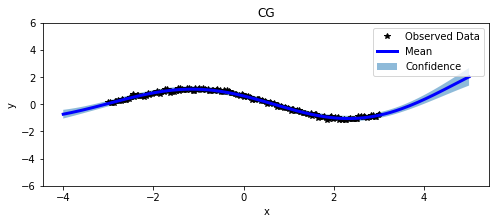

post training lengthscale = 3.40
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


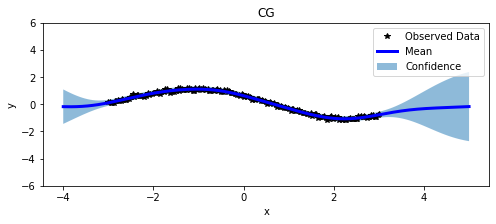

post training lengthscale = 1.12
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


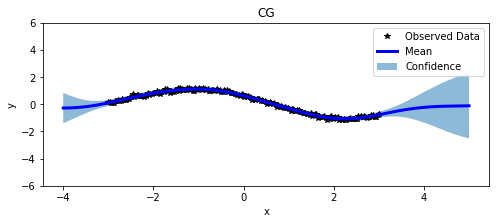

post training lengthscale = 1.23
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


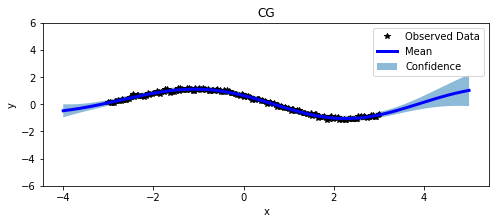

post training lengthscale = 2.28
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


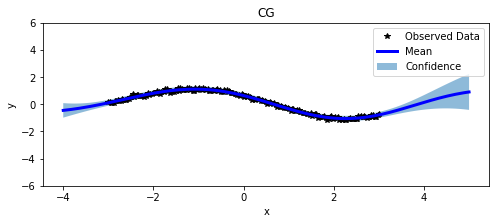

post training lengthscale = 2.09
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


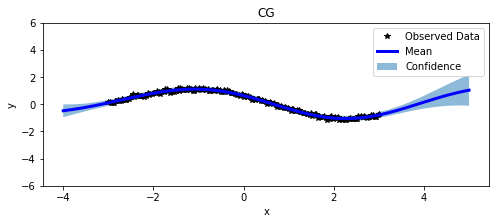

post training lengthscale = 2.30
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


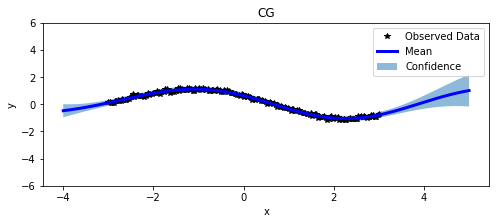

post training lengthscale = 2.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


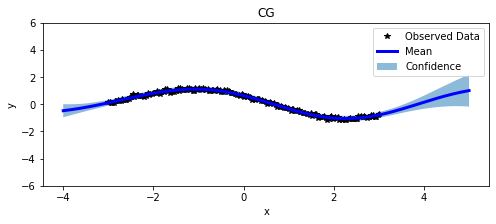

post training lengthscale = 2.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


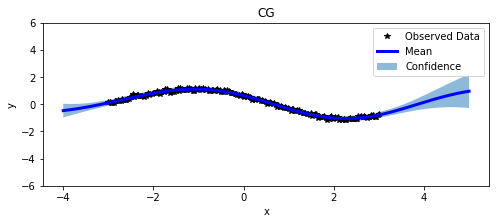

post training lengthscale = 2.18
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


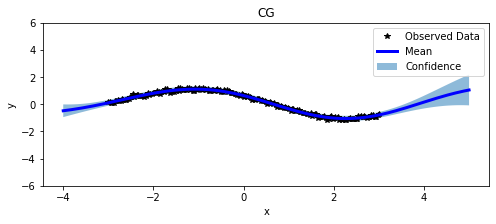

post training lengthscale = 2.32
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


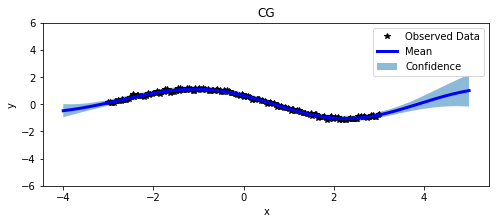

post training lengthscale = 2.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


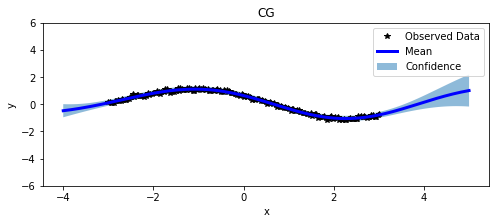

post training lengthscale = 2.26
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.7049437761306763 2.0
2.2514867782592773


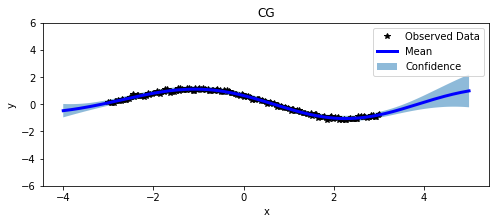

post training lengthscale = 2.22
true lengthscale= 2.00


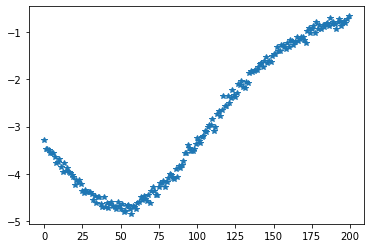

pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


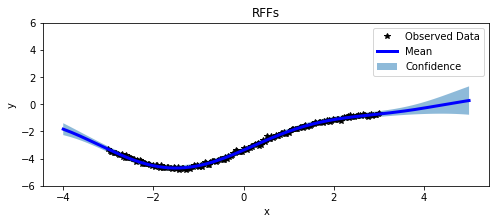

post training lengthscale
1.2319566011428833
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


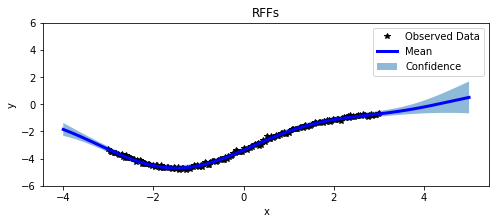

post training lengthscale
1.792999505996704
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


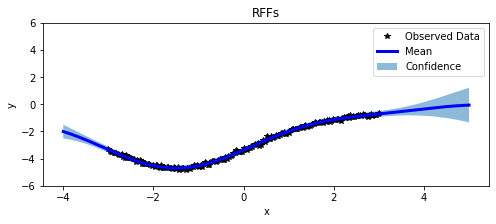

post training lengthscale
1.8828703165054321
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


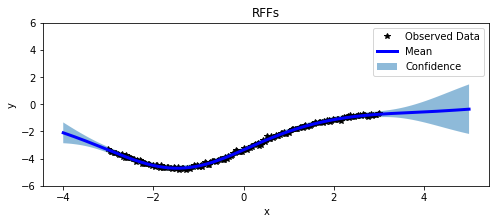

post training lengthscale
1.860068678855896
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


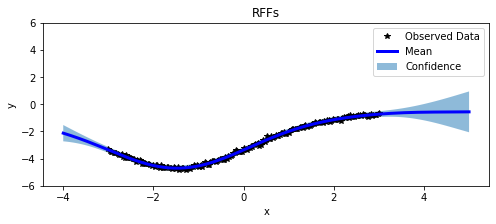

post training lengthscale
1.9095267057418823
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


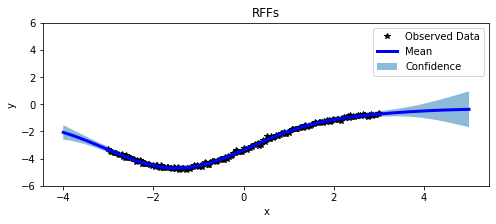

post training lengthscale
2.0025665760040283
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


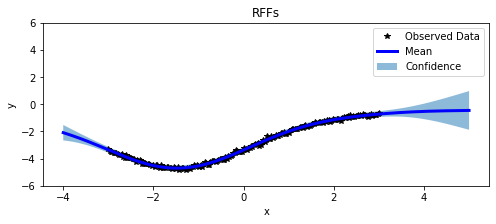

post training lengthscale
1.9825247526168823
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


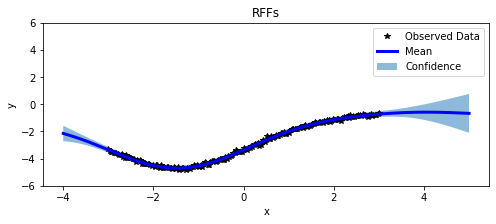

post training lengthscale
1.9148520231246948
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


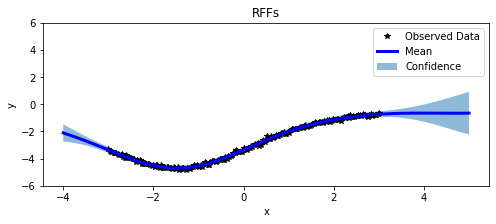

post training lengthscale
1.975786566734314
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


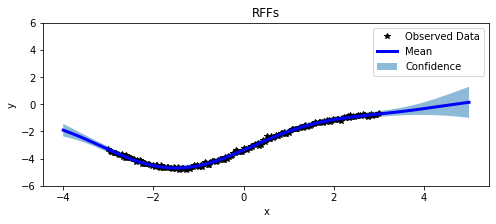

post training lengthscale
2.016645908355713
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


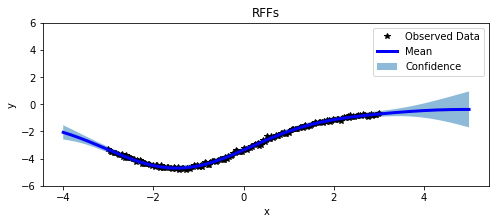

post training lengthscale
2.0034356117248535
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


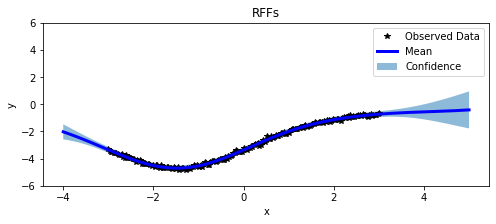

post training lengthscale
1.998561143875122
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


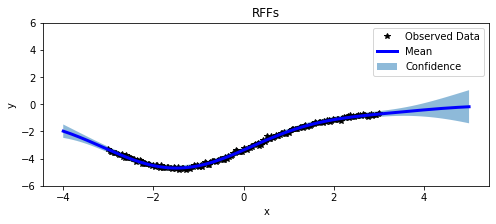

post training lengthscale
2.0391368865966797
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


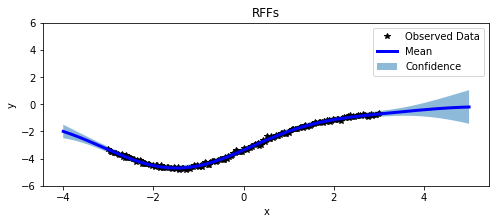

post training lengthscale
2.051570415496826
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


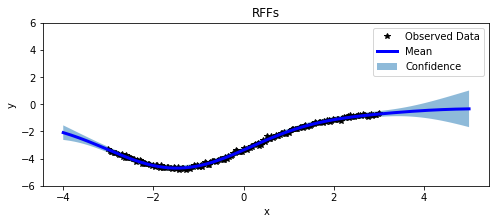

post training lengthscale
2.006974458694458
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


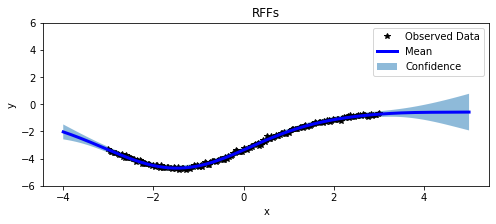

post training lengthscale
2.0329251289367676
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


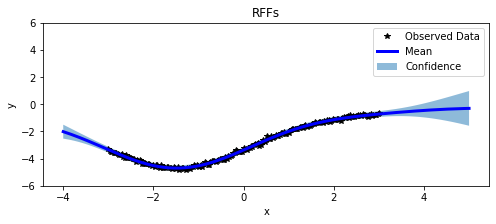

post training lengthscale
2.0469088554382324
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


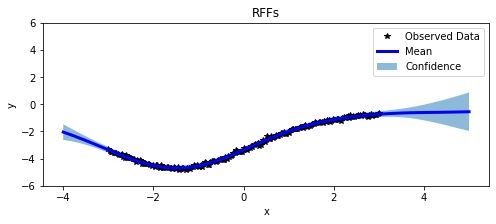

post training lengthscale
2.0774085521698
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 1.3371024131774902 2.0
1.3371024131774902


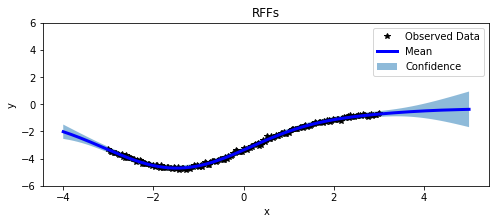

post training lengthscale
2.048924207687378
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


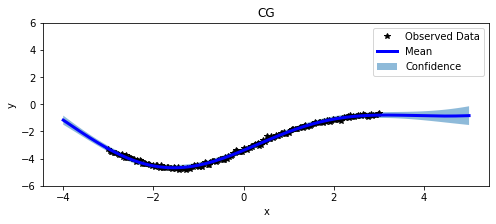

post training lengthscale = 3.25
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


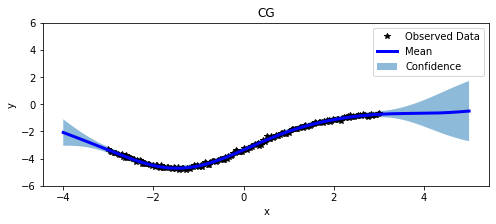

post training lengthscale = 1.36
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


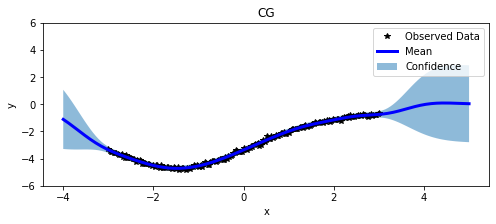

post training lengthscale = 0.71
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


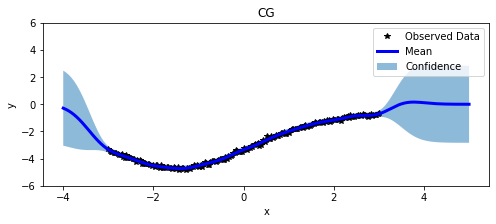

post training lengthscale = 0.46
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


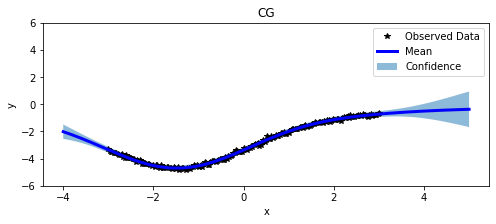

post training lengthscale = 2.10
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


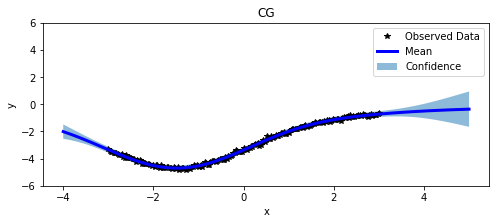

post training lengthscale = 2.11
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


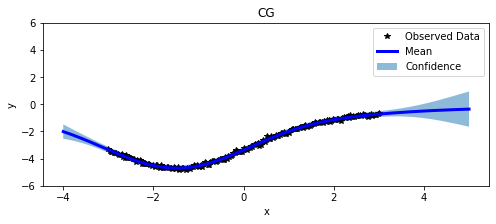

post training lengthscale = 2.11
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


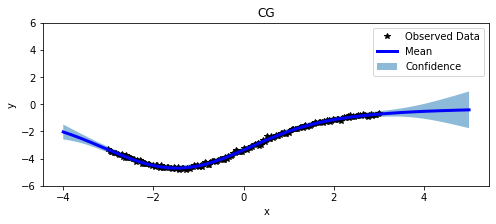

post training lengthscale = 2.05
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


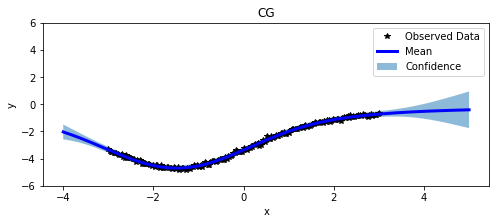

post training lengthscale = 2.05
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


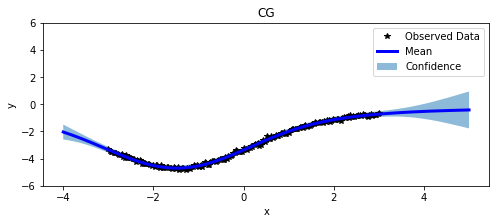

post training lengthscale = 2.04
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


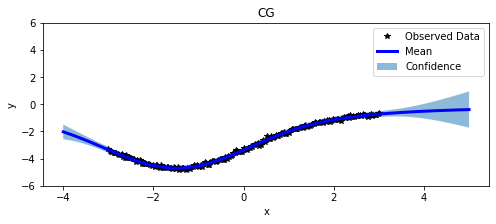

post training lengthscale = 2.07
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


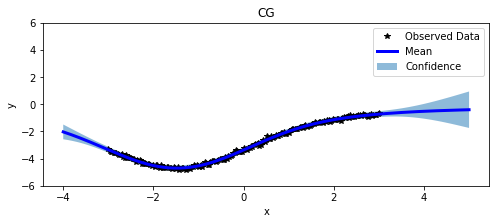

post training lengthscale = 2.06
pre training: likelihood noise; kernel lengthscale; outputscale
0.010000001639127731 0.26113152503967285 2.0
2.048924207687378


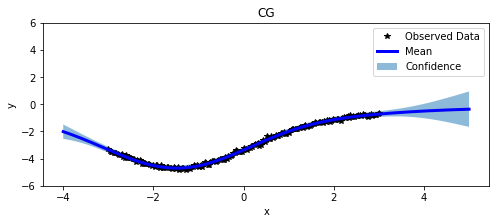

post training lengthscale = 2.10


In [335]:
import time
torch.manual_seed(0)

recovered_lengthscales_RFF = np.zeros((len(lengthscale_vec), 
                                   len(RFF_samples)))

recovered_lengthscales_CG = np.zeros((len(lengthscale_vec), 
                                   len(CG_iters)))

training_time_RFF = np.zeros_like(recovered_lengthscales_RFF)
training_time_CG = np.zeros_like(recovered_lengthscales_CG)

rand_init_lengthscales_RFF = (lengthscale_vec[0] - lengthscale_vec[-1]) * \
            torch.rand(len(lengthscale_vec)) + lengthscale_vec[-1]
rand_init_lengthscales_CG = (lengthscale_vec[0] - lengthscale_vec[-1]) * \
            torch.rand(len(lengthscale_vec)) + lengthscale_vec[-1]

for i in range(len(lengthscale_vec)):
    
    # re-initialize true model
    true_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    true_model = GPRegressionModel(train_x, train_y, true_likelihood) 
    
    '''see basic usage tutorial on 
    https://docs.gpytorch.ai/en/v1.2.0/examples/00_Basic_Usage/Hyperparameters.html'''
    hypers = {
    'likelihood.noise_covar.noise': torch.tensor(.005),
    'covar_module.base_kernel.lengthscale': torch.tensor(lengthscale_vec[i]),
    'covar_module.outputscale': torch.tensor(2.),
    }

    true_model.initialize(**hypers)
    
    print("true lengthscale= %.2f" % true_model.covar_module.base_kernel.lengthscale.item())
#     print(
#         true_model.likelihood.noise_covar.noise.item(),
#         true_model.covar_module.base_kernel.lengthscale.item(),
#         true_model.covar_module.outputscale.item()
#     )
    
    train_y = sample_from_prior(true_model, true_likelihood, train_x)
    plt.plot(train_y, '*')
    plt.show()

    for j in range(len(RFF_samples)):
        
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = GPRegressionModelRFF(train_x, train_y, 
                                 likelihood, 
                                 num_rff_samples=RFF_samples[j])
        hypers = {
            'likelihood.noise_covar.noise': torch.tensor(.01),
            'covar_module.base_kernel.lengthscale': rand_init_lengthscales_RFF[i],
            'covar_module.outputscale': torch.tensor(2.),
            }
        
        model.initialize(**hypers)
        
        print('pre training: likelihood noise; kernel lengthscale; outputscale')
        print(
            model.likelihood.noise_covar.noise.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.covar_module.outputscale.item()
        )        #model.covar_module.base_kernel.lengthscale = rand_init_lengthscales_RFF[j]
        print(model.covar_module.base_kernel.lengthscale.item())

        with gpytorch.settings.max_cholesky_size(10000000):
            start = time.time()
            train(model, likelihood, name="RFFs")
            train_time = time.time()-start
            eval(model, likelihood, name="RFFs")
            plt.show()
            

        print('post training lengthscale')
        print(model.covar_module.base_kernel.lengthscale.item())

        recovered_lengthscales_RFF[i,j] = model.covar_module.base_kernel.lengthscale.item()
        training_time_RFF[i,j] = train_time
        
    for c in range(len(CG_iters)):
        
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        CG_model = GPRegressionModel(train_x, train_y, likelihood)
        
        hypers = {
            'likelihood.noise_covar.noise': torch.tensor(.01),
            'covar_module.base_kernel.lengthscale': rand_init_lengthscales_CG[i],
            'covar_module.outputscale': torch.tensor(2.),
            }
        
        CG_model.initialize(**hypers)
        print('pre training: likelihood noise; kernel lengthscale; outputscale')
        print(
            CG_model.likelihood.noise_covar.noise.item(),
            CG_model.covar_module.base_kernel.lengthscale.item(),
            CG_model.covar_module.outputscale.item()
        )        #model.covar_module.base_kernel.lengthscale = rand_init_lengthscales_RFF[j]
        print(model.covar_module.base_kernel.lengthscale.item())
        # train
        start = time.time()
        CG_training(CG_model, likelihood, CG_iters[c]) # context managing around train()
        train_time = time.time()-start
        # eval
        with gpytorch.settings.max_cholesky_size(100000000):
            eval(CG_model, likelihood, name="CG")
            plt.show()
        
        print('post training lengthscale = %.2f' % CG_model.covar_module.base_kernel.lengthscale.item())
        recovered_lengthscales_CG[i,c] = CG_model.covar_module.base_kernel.lengthscale.item()
        training_time_CG[i,c] = train_time

    

In [336]:
true_vec_RFF = np.repeat(lengthscale_vec, recovered_lengthscales_RFF.shape[1])
recovered_vec_RFF = recovered_lengthscales_RFF.reshape(
    recovered_lengthscales_RFF.shape[0]*recovered_lengthscales_RFF.shape[1])
RFF_samples_vec = np.tile(RFF_samples,  
                          recovered_lengthscales_RFF.shape[0])
runtime_vec_RFF = training_time_RFF.reshape(
    training_time_RFF.shape[0]*training_time_RFF.shape[1])
print(recovered_vec_RFF.shape)

(209,)


In [337]:
true_vec_CG = np.repeat(lengthscale_vec, recovered_lengthscales_CG.shape[1])
recovered_vec_CG = recovered_lengthscales_CG.reshape(
    recovered_lengthscales_CG.shape[0]*recovered_lengthscales_CG.shape[1])
runtime_vec_CG = training_time_CG.reshape(
    training_time_CG.shape[0]*training_time_CG.shape[1])
CG_iters_vec = np.tile(CG_iters,  
                          recovered_lengthscales_CG.shape[0])
print(recovered_vec_CG.shape)

(143,)


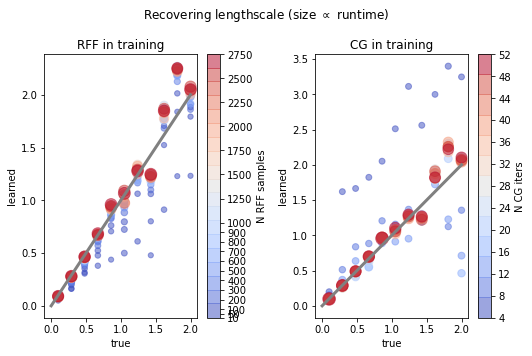

In [355]:
fig, ax = plt.subplots(1,2, figsize = (7.5,5))

# RFF
ax[0].plot([0,lengthscale_vec[-1]], [0,lengthscale_vec[-1]], 'gray')
scat0 = ax[0].scatter(true_vec_RFF, recovered_vec_RFF, 
            c = RFF_samples_vec, s = runtime_vec_RFF*10,
           cmap=plt.cm.get_cmap('coolwarm', len(RFF_samples)), alpha=.5)
fig.colorbar(scat0, ticks=RFF_samples, label='N RFF samples', ax=ax[0])
ax[0].set_xlabel("true")
ax[0].set_ylabel("learned")
ax[0].set_title("RFF in training")

# CG
ax[1].plot([0,lengthscale_vec[-1]], [0,lengthscale_vec[-1]], 'gray')
scat1 = ax[1].scatter(true_vec_CG, recovered_vec_CG, 
            c = CG_iters_vec, s = runtime_vec_CG*10,
           cmap=plt.cm.get_cmap('coolwarm', len(CG_iters)), alpha=.5)
fig.colorbar(scat1, ticks=CG_iters, label='N CG iters', ax=ax[1])
ax[1].set_xlabel("true")
ax[1].set_ylabel("learned")
ax[1].set_title("CG in training")
fig.suptitle('Recovering lengthscale (size ' + r'$\propto$' + ' runtime)')
fig.tight_layout()
plt.savefig('RFF_CG_initial_sim.png')

In [344]:
recovered_vec_RFF.shape
print(true_vec_RFF.shape)
print(RFF_samples.shape)
print(lengthscale_vec.shape)

(209,)
(19,)
(11,)


In [348]:
# division plot
#print(recovered_lengthscales_RFF)
lengthscale_mat_RFF = np.tile(lengthscale_vec.reshape(-1,1), 
                              (1,RFF_samples.shape[0]))
div_error_RFF = recovered_lengthscales_RFF/lengthscale_mat_RFF
lengthscale_mat_CG = np.tile(lengthscale_vec.reshape(-1,1), 
                              (1,CG_iters.shape[0]))
div_error_CG = recovered_lengthscales_CG/lengthscale_mat_CG
#print(lengthscale_mat)

In [349]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3.0

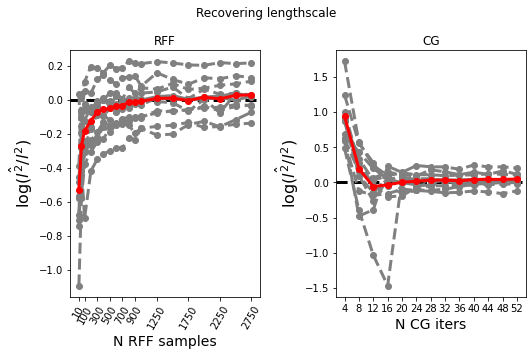

In [366]:
fig, ax = plt.subplots(1,2, figsize = (7.5,5))
ax[0].axhline(y=0.0, linestyle = 'dashed', color = 'black');
ax[0].plot(RFF_samples, np.log(div_error_RFF.T), '--o', color = 'gray');
ax[0].plot(RFF_samples, np.log(np.mean(div_error_RFF,axis=0)), '-o', color = 'red')
ax[0].set_xticks(RFF_samples[np.arange(0, len(RFF_samples), 2)])
ax[0].set_xticklabels(RFF_samples[np.arange(0, len(RFF_samples), 2)], rotation=60)
ax[0].set_title('RFF')
ax[0].set_xlabel('N RFF samples', fontsize = 14)
ax[0].set_ylabel(r'$\log(\hat{l^2}/{l^2})$', fontsize=16)
ax[1].axhline(y=0.0, linestyle = 'dashed', color = 'black');
ax[1].plot(CG_iters, np.log(div_error_CG.T), '--o', color = 'gray');
ax[1].plot(CG_iters, np.log(np.mean(div_error_CG,axis=0)), '-o', color = "red")
ax[1].set_xticks(CG_iters);
ax[1].set_title('CG')
ax[1].set_xlabel('N CG iters', fontsize = 14)
ax[1].set_ylabel(r'$\log(\hat{l^2}/{l^2})$', fontsize=16)
fig.suptitle('Recovering lengthscale')
fig.tight_layout()
plt.savefig('div_err_more_iters.png')

In [244]:
# division:
plt.plot(RFF_samples_vec, 
         recovered_vec_RFF/true_vec_RFF)

ValueError: RGBA sequence should have length 3 or 4

<Figure size 432x288 with 1 Axes>

Text(0.5, 1.0, 'Time')

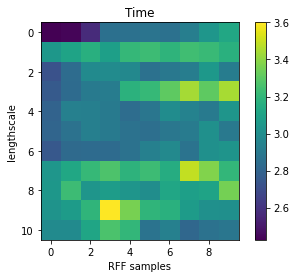

In [202]:
plt.imshow(training_time_RFF)
plt.colorbar()
plt.ylabel('lengthscale')
plt.xlabel('RFF samples')
plt.title('Time')

Text(0.5, 1.0, 'Time')

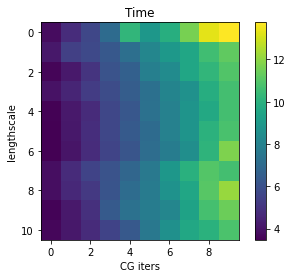

In [203]:
plt.imshow(training_time_CG)
plt.colorbar()
plt.ylabel('lengthscale')
plt.xlabel('CG iters')
plt.title('Time')

In [187]:
train_x = torch.linspace(-5, 5, 200)
train_y = torch.sin(train_x * (5 * math.pi)) * train_x + torch.randn_like(train_x) * 0.1
test_x = torch.linspace(-6, 7, 151)

9.999999747378752e-05 2.0 20.0


/Users/danbiderman/Dropbox/Columbia/1.Dan/John/GP-project/gpytorch/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


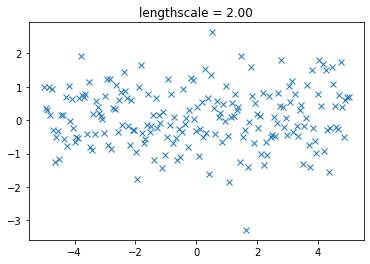

In [195]:
# re-initialize true model
true_likelihood = gpytorch.likelihoods.GaussianLikelihood()
true_model = True_GPRegressionModel(train_x, train_y, likelihood) 
hypers = {
'likelihood.noise_covar.noise': torch.tensor(.0001),
'covar_module.base_kernel.lengthscale': torch.tensor(2.),
'covar_module.outputscale': torch.tensor(20.),
}

true_model.initialize(**hypers)
print(
    true_model.likelihood.noise_covar.noise.item(),
    true_model.covar_module.base_kernel.lengthscale.item(),
    true_model.covar_module.outputscale.item()
)

true_model.eval()
true_likelihood.eval()

preds = true_likelihood(true_model(train_x))
train_y = preds.sample() # true y, make sure that there are no duplicates

plt.plot(train_x, GP_sample.detach().numpy(), 'x')
plt.title('lengthscale = %.2f' % true_model.covar_module.base_kernel.lengthscale.item())
plt.show()